## Importations

In [1]:
## plots
import matplotlib.pyplot as plt
from matplotlib import rc

##
import numpy as np

import sys
sys.path.append('../')

## ML :
from scripts.machine_learning_utils import *
from scripts.models import *
from scripts.descriptors import *


import pandas as pd



rc('font', family='sans-serif', size = 7)
rc('figure', dpi= 700)
rc(('xtick', 'ytick'), labelsize = 7)
rc('legend', fontsize=6)
rc('lines', linewidth = 1)
rc('axes', linewidth = 0.5, labelsize =8)
rc('legend', handlelength = 2)

Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Get data

In [2]:
df_total = pd.read_csv('../tables/data/df_total.csv').set_index('SMILES')

df_OCO = df_total[df_total.group == 'OCO']
df_ONO = df_total[df_total.group == 'ONO']
df_NNN = df_total[df_total.group == 'NNN']
df_triarylboranes = df_total[df_total.group == "triarylboranes"]

In [3]:
X = create_descriptors(df_total.index, "quantum")
#X = create_descriptors(df_ONO.index, "quantum")
names = get_names('quantum')
df_X = pd.DataFrame(X)
df_X.columns = names

In [4]:
Y = df_total.FIA
#Y = df_ONO.FIA

## Hierarchical clustering

In [25]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
import seaborn as sns

In [28]:
reduced_features = list(names[:])
reduced_features.remove("multiplicity")
reduced_features.remove("charge")
reduced_features.remove("converged")

df_X = df_X.loc[:,reduced_features] 
#remove features not seen during fit

In [29]:
corr_sp = df_X.corr('spearman') #correlation matrix

distance_sp = 1 - abs(corr_sp) #distance matrix

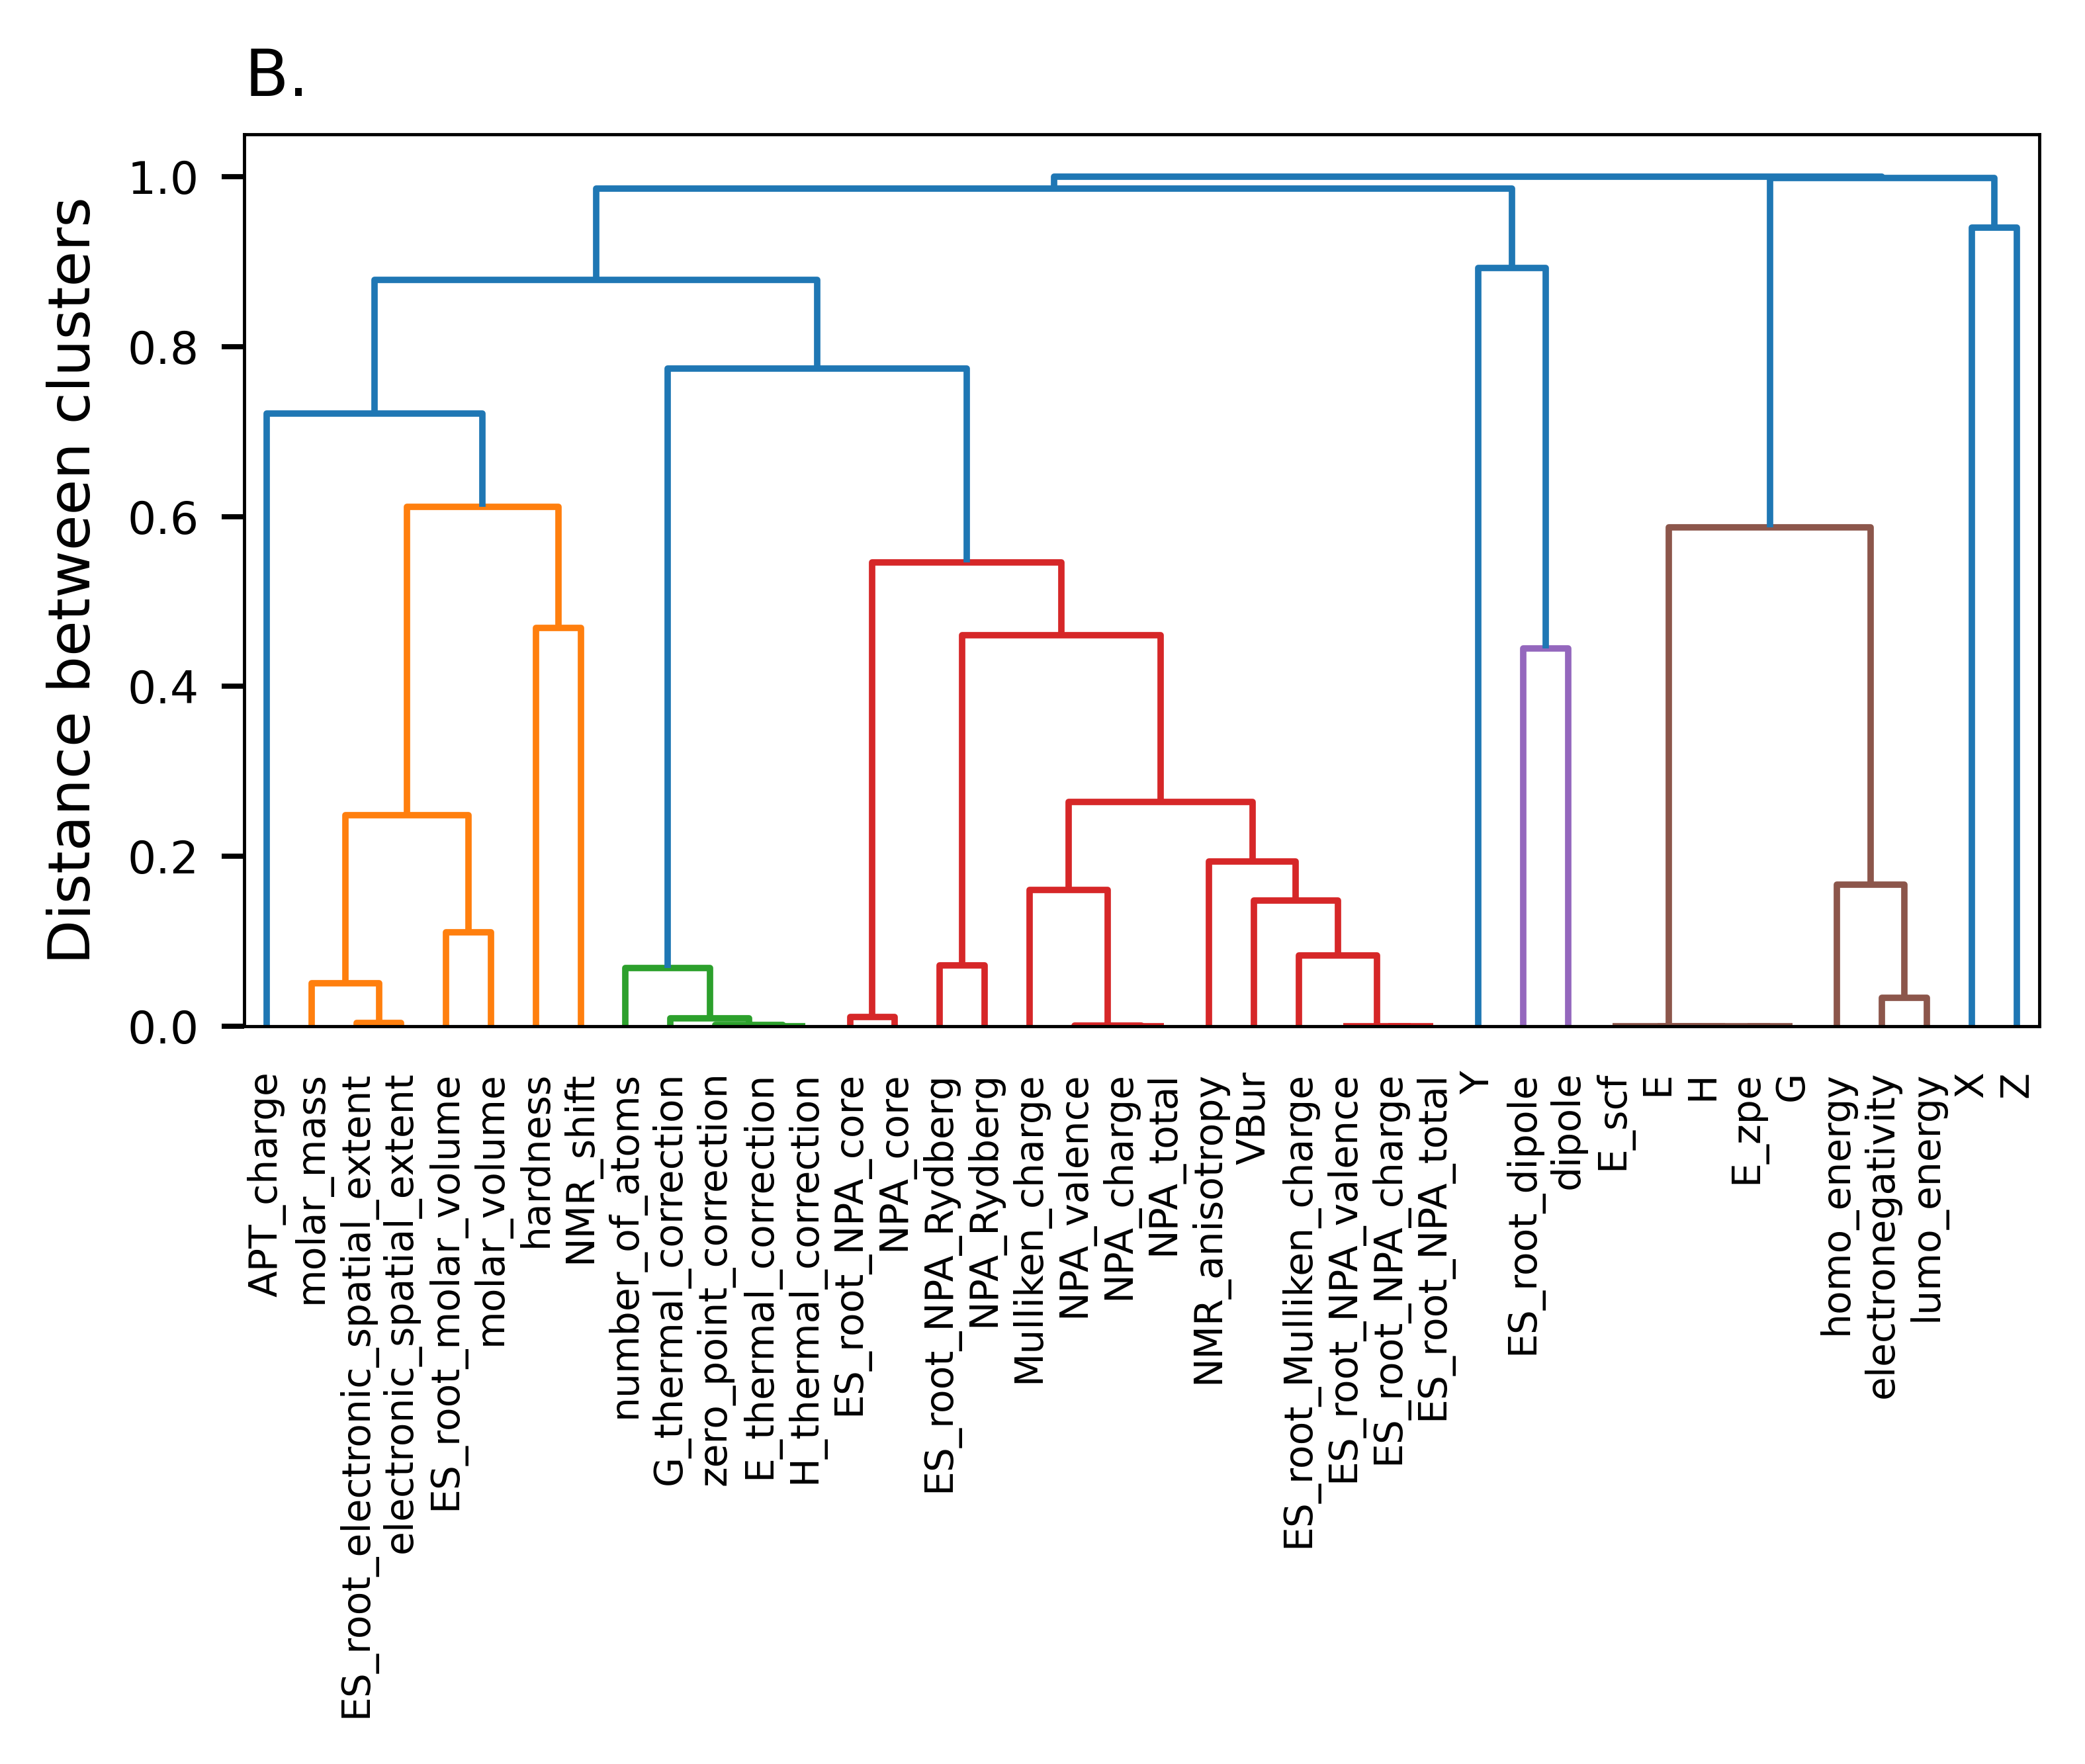

In [30]:
fig, ax = plt.subplots(figsize=(5,2.5))
Z = hierarchy.linkage(squareform(distance_sp), 'complete')

plt.ylabel("Distance between clusters", size = 9)
hierarchy.dendrogram(Z, labels=df_X.columns, orientation='top', 
           leaf_rotation=90);
plt.xticks(fontsize = 6)

ax.set_title('B.', loc='left', fontsize =10)

fig.savefig(f'../results/interpretability/quantum_descriptors/hierarchy_clustering_complete_linkage_quantum_descr_df_all.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

In [31]:
from collections import defaultdict


cluster_ids = hierarchy.fcluster(Z, 0.45, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(df_X.columns[idx])
#selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
#selected_features_names = X.columns[selected_features] # renvoie le nom de la feature d'indice le plus bas du cluster. 
#Donc pas de choix particulier.

In [32]:
cluster_id_to_feature_ids

defaultdict(list,
            {11: ['E', 'E_scf', 'E_zpe', 'G', 'H'],
             9: ['ES_root_dipole', 'dipole'],
             1: ['ES_root_electronic_spatial_extent',
              'ES_root_molar_volume',
              'electronic_spatial_extent',
              'molar_mass',
              'molar_volume'],
             5: ['E_thermal_correction',
              'G_thermal_correction',
              'H_thermal_correction',
              'number_of_atoms',
              'zero_point_correction'],
             12: ['electronegativity', 'homo_energy', 'lumo_energy'],
             2: ['hardness'],
             4: ['APT_charge'],
             8: ['ES_root_Mulliken_charge',
              'ES_root_NPA_charge',
              'ES_root_NPA_total',
              'ES_root_NPA_valence',
              'Mulliken_charge',
              'NMR_anisotropy',
              'NPA_charge',
              'NPA_total',
              'NPA_valence',
              'VBur'],
             7: ['ES_root_NPA_Rydberg', 'NPA

In [7]:
uncorrelated_features = ['H', 'dipole', 'molar_volume', 'H_thermal_correction', 'electronegativity', 'hardness', "APT_charge", "NPA_charge", "NPA_Rydberg", 'NPA_core', 'NMR_shift', 'X']

Reduce descriptors to uncorrelated features

In [8]:
names = get_names('quantum')
df_X = pd.DataFrame(X)
df_X.columns = names
df_X_uncor = df_X.loc[:,uncorrelated_features]
X_uncor = np.array(df_X_uncor)

#### Interprete coeffs

Fit the model

In [5]:
model_linear = LinearRegression()
pipeline = Pipeline(steps=[('selector', VarianceThreshold()),('scaler', StandardScaler()),('m',model_linear)])

In [9]:
pipeline.fit(X_uncor,Y)

Pipeline(steps=[('selector', VarianceThreshold()), ('scaler', StandardScaler()),
                ('m', LinearRegression())])

In [10]:
## to get the features seen during fit of the model

#names = get_names(descriptors)
fitted_features = list(pipeline[:-1].get_feature_names_out(uncorrelated_features))
print(fitted_features)
print(len(fitted_features))

['H', 'dipole', 'molar_volume', 'H_thermal_correction', 'electronegativity', 'hardness', 'APT_charge', 'NPA_charge', 'NPA_Rydberg', 'NPA_core', 'NMR_shift', 'X']
12


In [18]:
coefs = pd.DataFrame(
    model_linear.coef_,
    columns=["Coefficients"],
    index=fitted_features,
)
coefs["Absolute coef"] = abs(coefs["Coefficients"])

more_important_coefs = coefs.sort_values("Absolute coef", ascending = True)

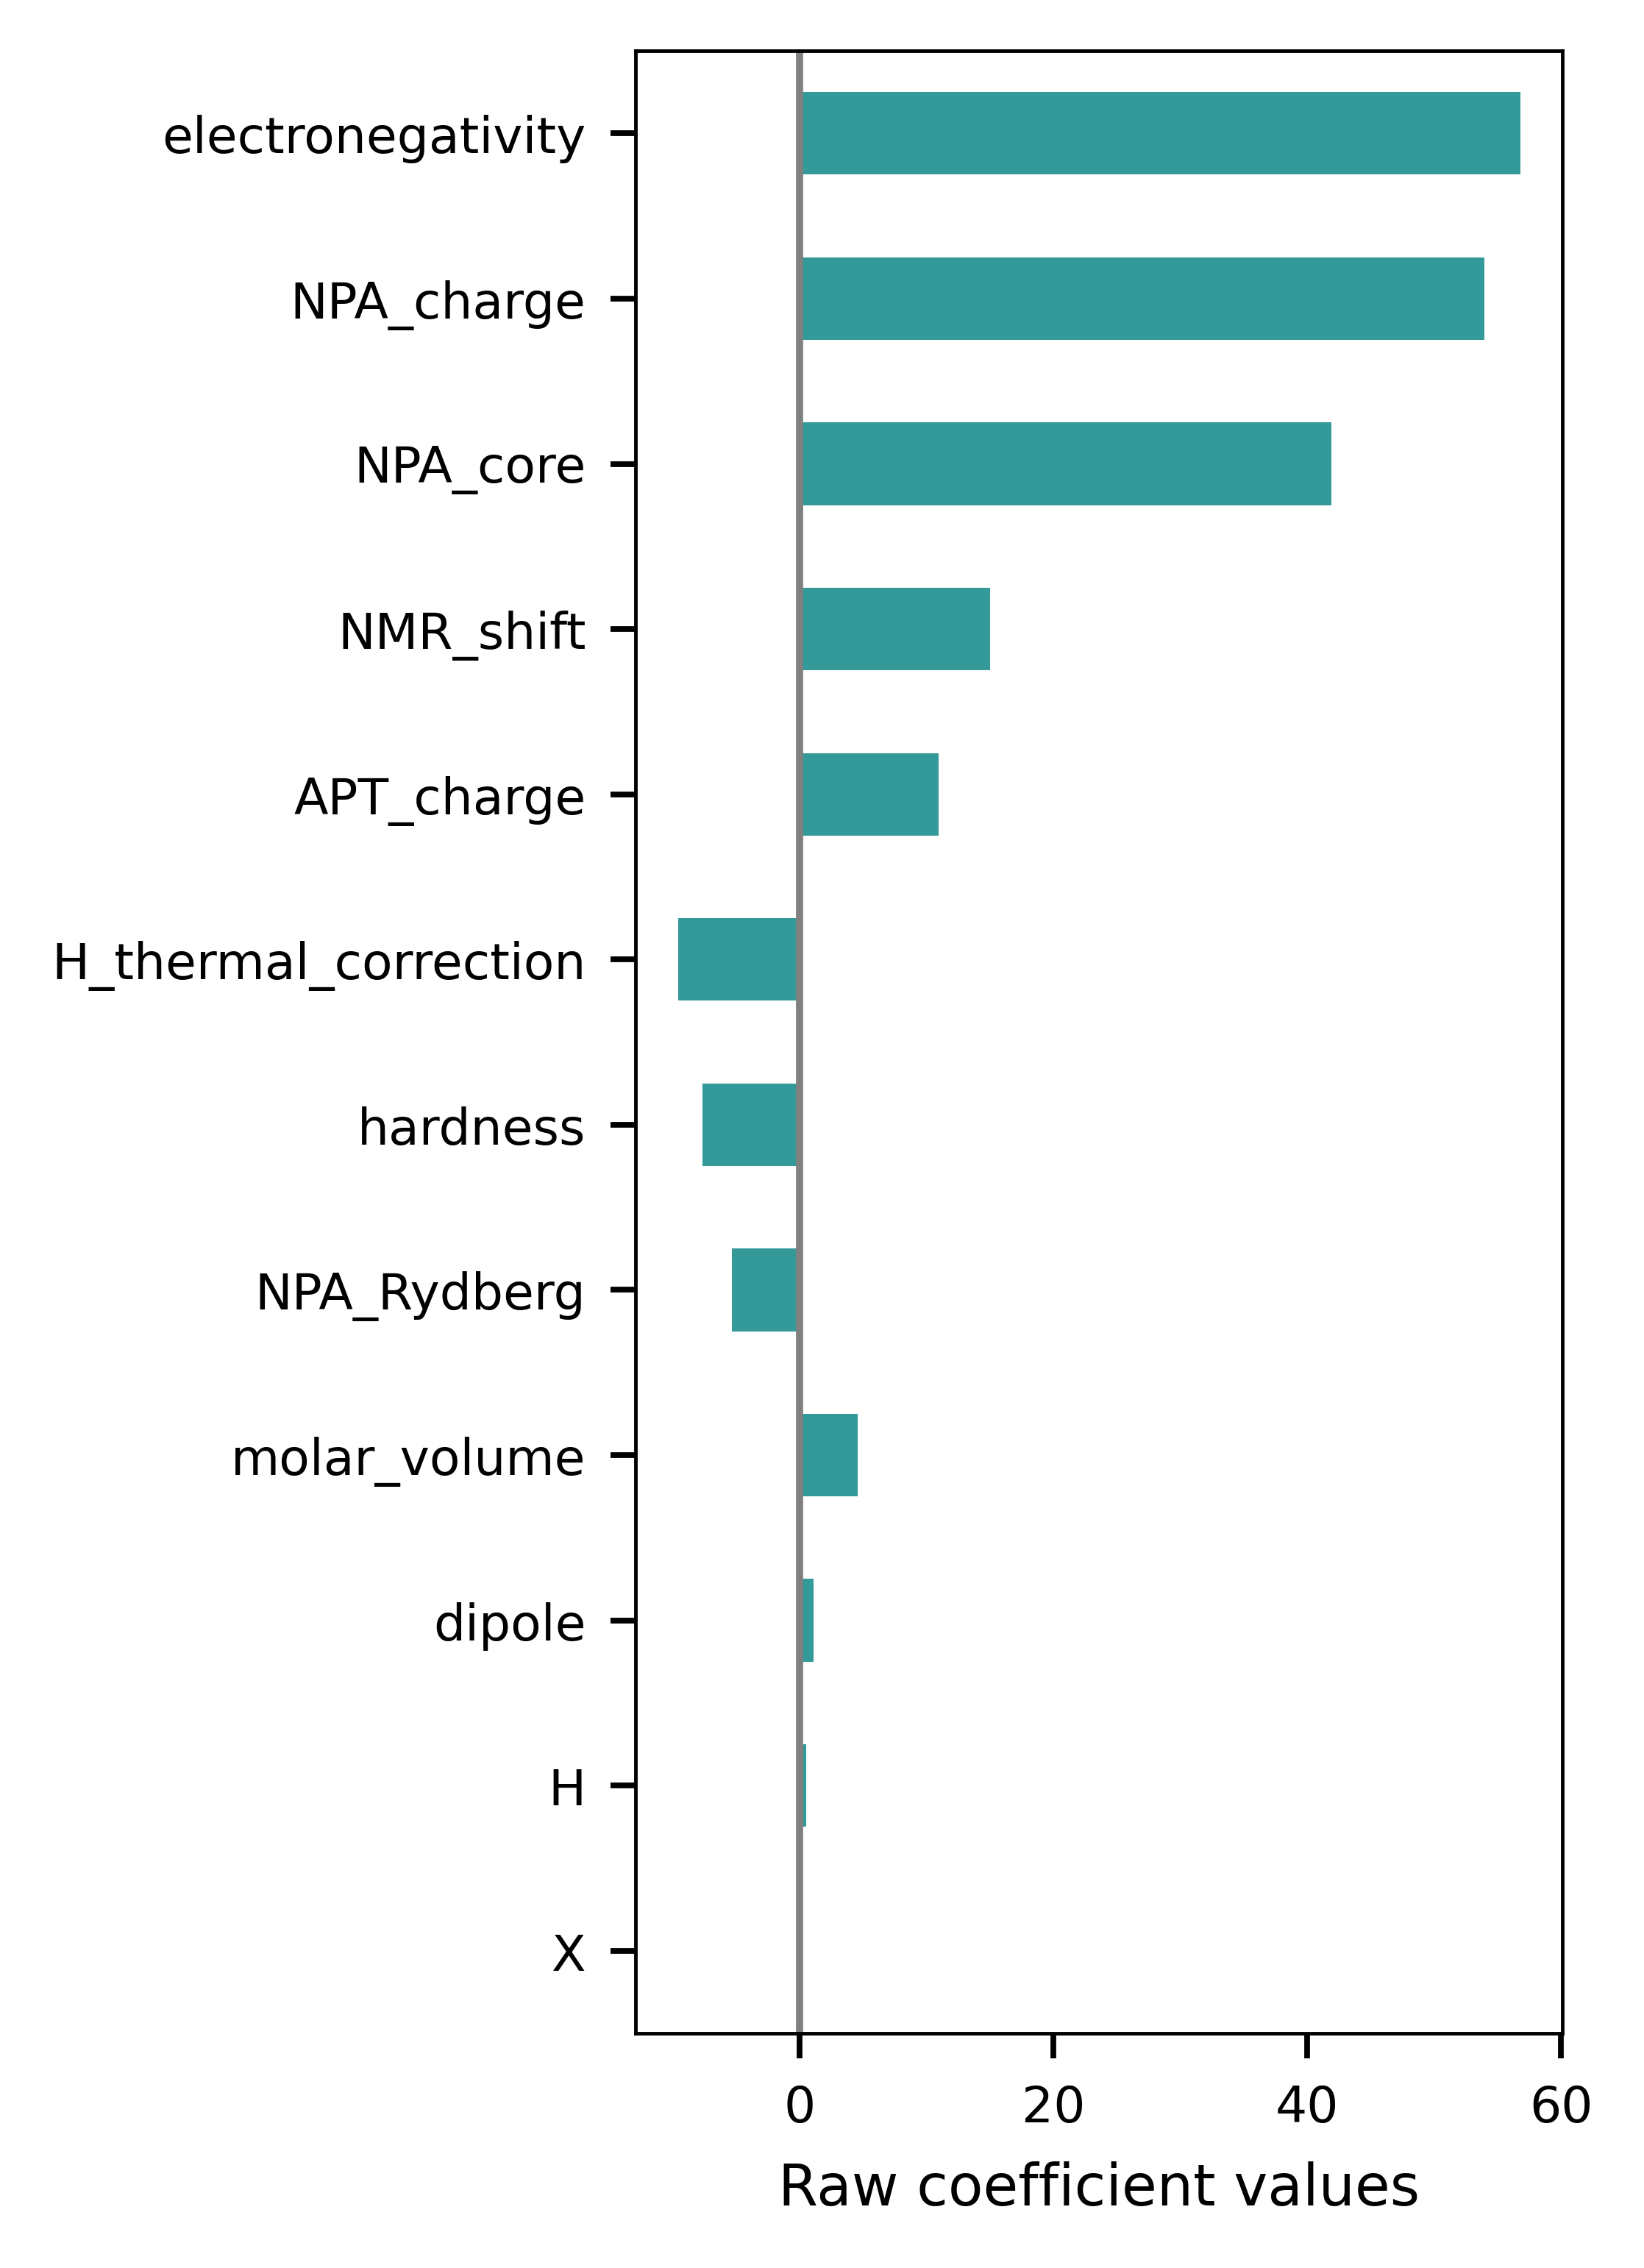

In [19]:
fig, ax = plt.subplots(figsize=(3, 5))

more_important_coefs["Coefficients"].plot.barh(color = 'teal', alpha = 0.8)
#ax.set_title('A.', loc='left', fontsize =10)
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

#fig.savefig(f'../results/interpretability/quantum_descriptors/coefficients_linear_model_ONO.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

## Permutation importance

#### Choosing uncorrelated features

#### generate descriptors and choose model

In [11]:
df_X_uncorr = df_X.loc[:,uncorrelated_features]
X_uncor = np.array(df_X_uncorr)
Y = df_total.FIA
model = dict_models["Grad. Boost."]['quantum']
n_rep = 10

In [19]:
scores = evaluate_model(model, X_perm, Y, n_rep =10)

np.mean(scores)

-14.642673939463165

In [12]:
df = pd.DataFrame(columns = dict_models.keys(),)

In [13]:
for model in df.columns: 
            print(model)
            try : 
                scores = evaluate_model(dict_models[model]['quantum'], X,Y, n_rep = 10)
                for i,elt in enumerate(scores) : 
                    if elt < -100:
                        scores = np.delete(scores,[0,i])
                        print('split diverged')
                MAE = abs(round(np.mean(scores),2))
                df.at["All features",model] = MAE
            except: df.at[descriptor, model] = "dv"

Linear
LR
Bayes. Ridge
LASSO
SVR
Tree
RF
Grad. Boost.
GPR
KNN
MLP


In [15]:
for model in df.columns: 
            print(model)
            try : 
                scores = evaluate_model(dict_models[model]['quantum'], X_uncor,Y, n_rep = 10)
                for i,elt in enumerate(scores) : 
                    if elt < -100:
                        scores = np.delete(scores,[0,i])
                        print('split diverged')
                MAE = abs(round(np.mean(scores),2))
                df.at["Uncorrelated features",model] = MAE
            except: df.at[descriptor, model] = "dv"

Linear
LR
Bayes. Ridge
LASSO
SVR
Tree
RF
Grad. Boost.
GPR
KNN
MLP


In [16]:
df

Linear     LR Bayes. Ridge  LASSO    SVR   Tree     RF  \
All features           16.27  18.09        16.82  16.18  18.16  21.53  14.58   
Uncorrelated features  20.93  21.21        21.01  20.96   21.8  20.69   15.7   

                      Grad. Boost.    GPR    KNN    MLP  
All features                 13.39  17.14  20.57   16.1  
Uncorrelated features        14.61  21.22  21.43  20.94

In [ ]:
df.to_excel('../results/interpretability/quantum_descriptors/models_evaluation_uncorrelated_features.xlsx')

RF & GB perform best

#### Permutation importance

In [20]:
from sklearn.inspection import permutation_importance

def get_mean_importances(model, n_rep, n_fold, X, Y, input_features):
    Pi = []
    
    for i in range(n_rep):
        
        KF = KFold(n_splits=n_fold, shuffle=True)#pas fixer le random state sinon il fait les meme split a chaque n_rep
        for i, (train_index, test_index) in enumerate(KF.split(X,Y)):
            X_train = X[train_index]
            X_test = X[test_index]
            Y_train = Y[train_index]
            Y_test = Y[test_index]
            selector = VarianceThreshold()
            selector.fit(X_train) ## features that have same value 
            X_train = selector.transform(X_train)# for every molecule are eliminated
            X_test = selector.transform(X_test)
            feature_names = selector.get_feature_names_out(input_features)#should nt change accross repetitions
            scaler = StandardScaler().fit(X_train) ## descriptors are scaled
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)    
            model.fit(X_train, Y_train)
            pi = permutation_importance(model, X_train, Y_train, scoring=None, 
                                n_repeats=10, # nb of shuffles for each feature
                                max_samples=3.0)
            Pi.append(pi)
    
    mean_importances = np.zeros((len(feature_names)))
    std = np.zeros((len(feature_names)))
    for i in range(len(Pi)):
        mean_importances += Pi[i]['importances_mean']
        std += Pi[i]['importances_std']
    mean_importances = mean_importances/len(Pi) #mean importance of each feature
    std = std/len(Pi)
    
    return(feature_names, mean_importances, std )

def more_important_features_mean(mean_importances, std, feature_names, imp_min):
    
    
    restr_names   = []
    restr_imp = []
    restr_std = []
    for i,imp in enumerate(mean_importances):
        if imp > imp_min:
            restr_names.append(feature_names[i])
            restr_imp.append(imp)
            restr_std.append(std[i])
    plt.bar(restr_names, restr_imp, yerr = restr_std)
    plt.xticks(rotation=25, rotation_mode='default', ha = 'right')
    plt.ylabel('importance (%)')
    plt.margins(0.2)
    plt.tight_layout()
    plt.show()
    
    #fig.savefig('figures/permutation_importance/important_params_quantum.png', transparent = False, format = 'png')
    
    return restr_names, restr_imp, restr_std

In [21]:
model_perm = dict_models["Grad. Boost."]['quantum']

In [23]:
feature_names, mean_importances, std = get_mean_importances(model_perm, 10, 10, X_uncor, Y, uncorrelated_features)

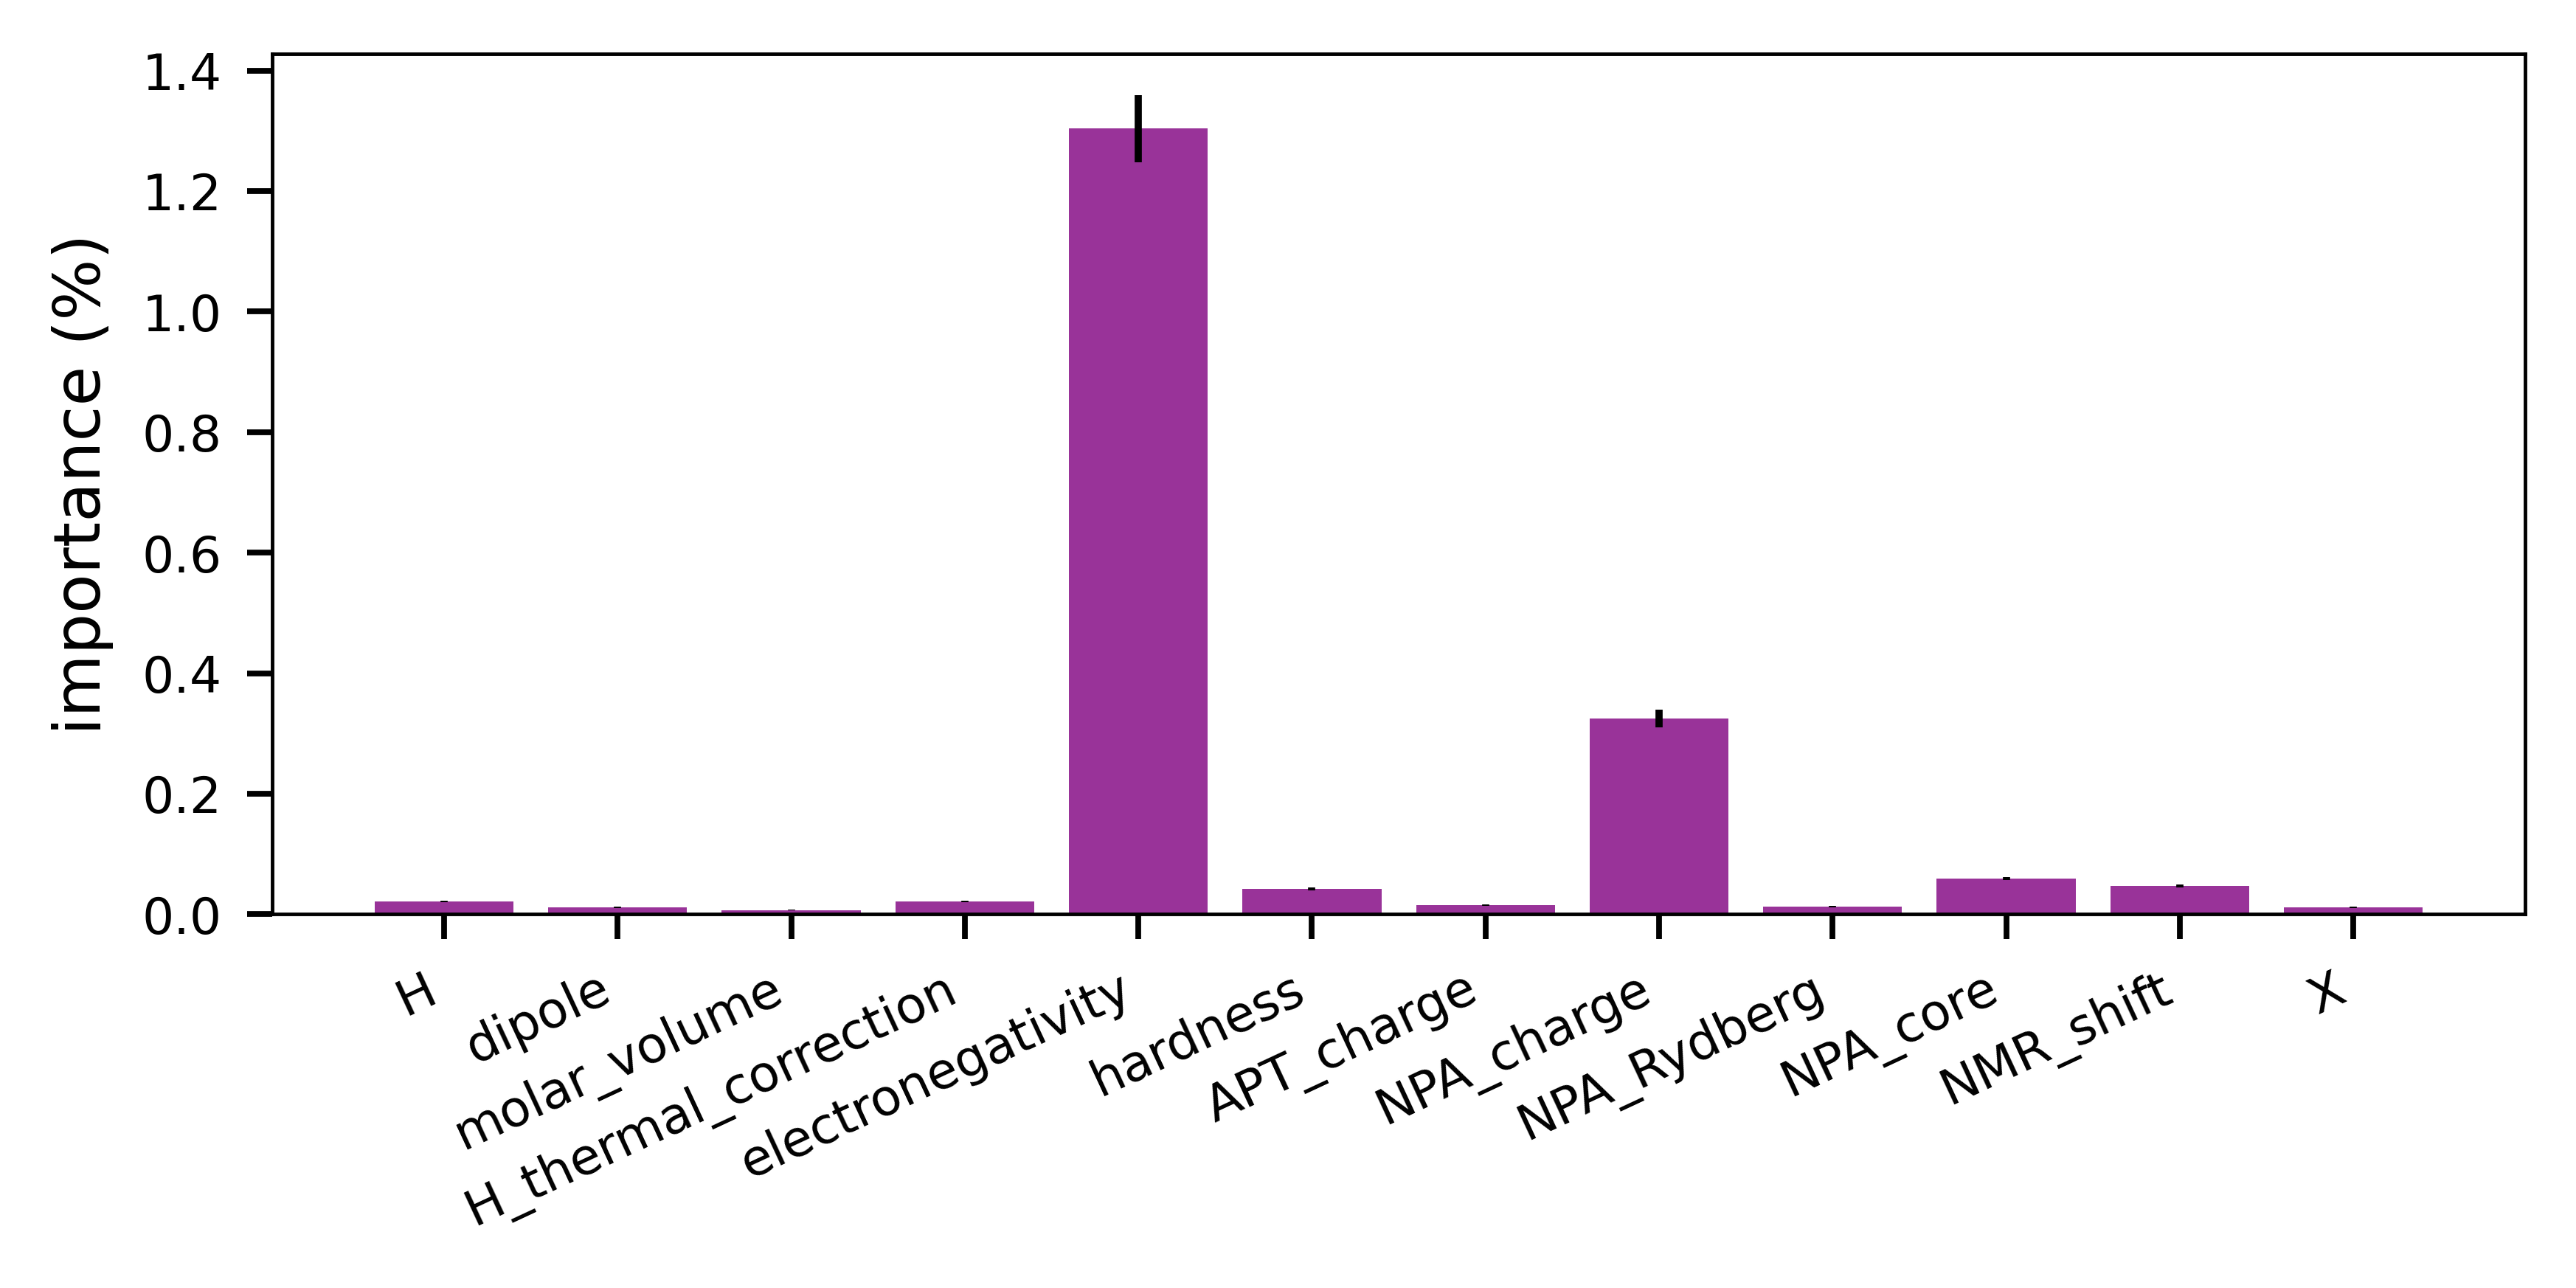

In [24]:

fig, ax = plt.subplots(figsize=(5,2.5))

plt.bar(feature_names, mean_importances, yerr = std, color = 'purple', alpha = 0.8)

plt.xticks(rotation=25, rotation_mode='default', ha = 'right', fontsize = 7)
#ax.set_title('C.', loc='left', fontsize =10)
plt.ylabel('importance (%)', size = 9)
#plt.margins(0.2)
plt.tight_layout()
plt.show()

#fig.savefig(f'article/figures/permutation_importance_quantum_Ridge.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')
    

### Plot final figure

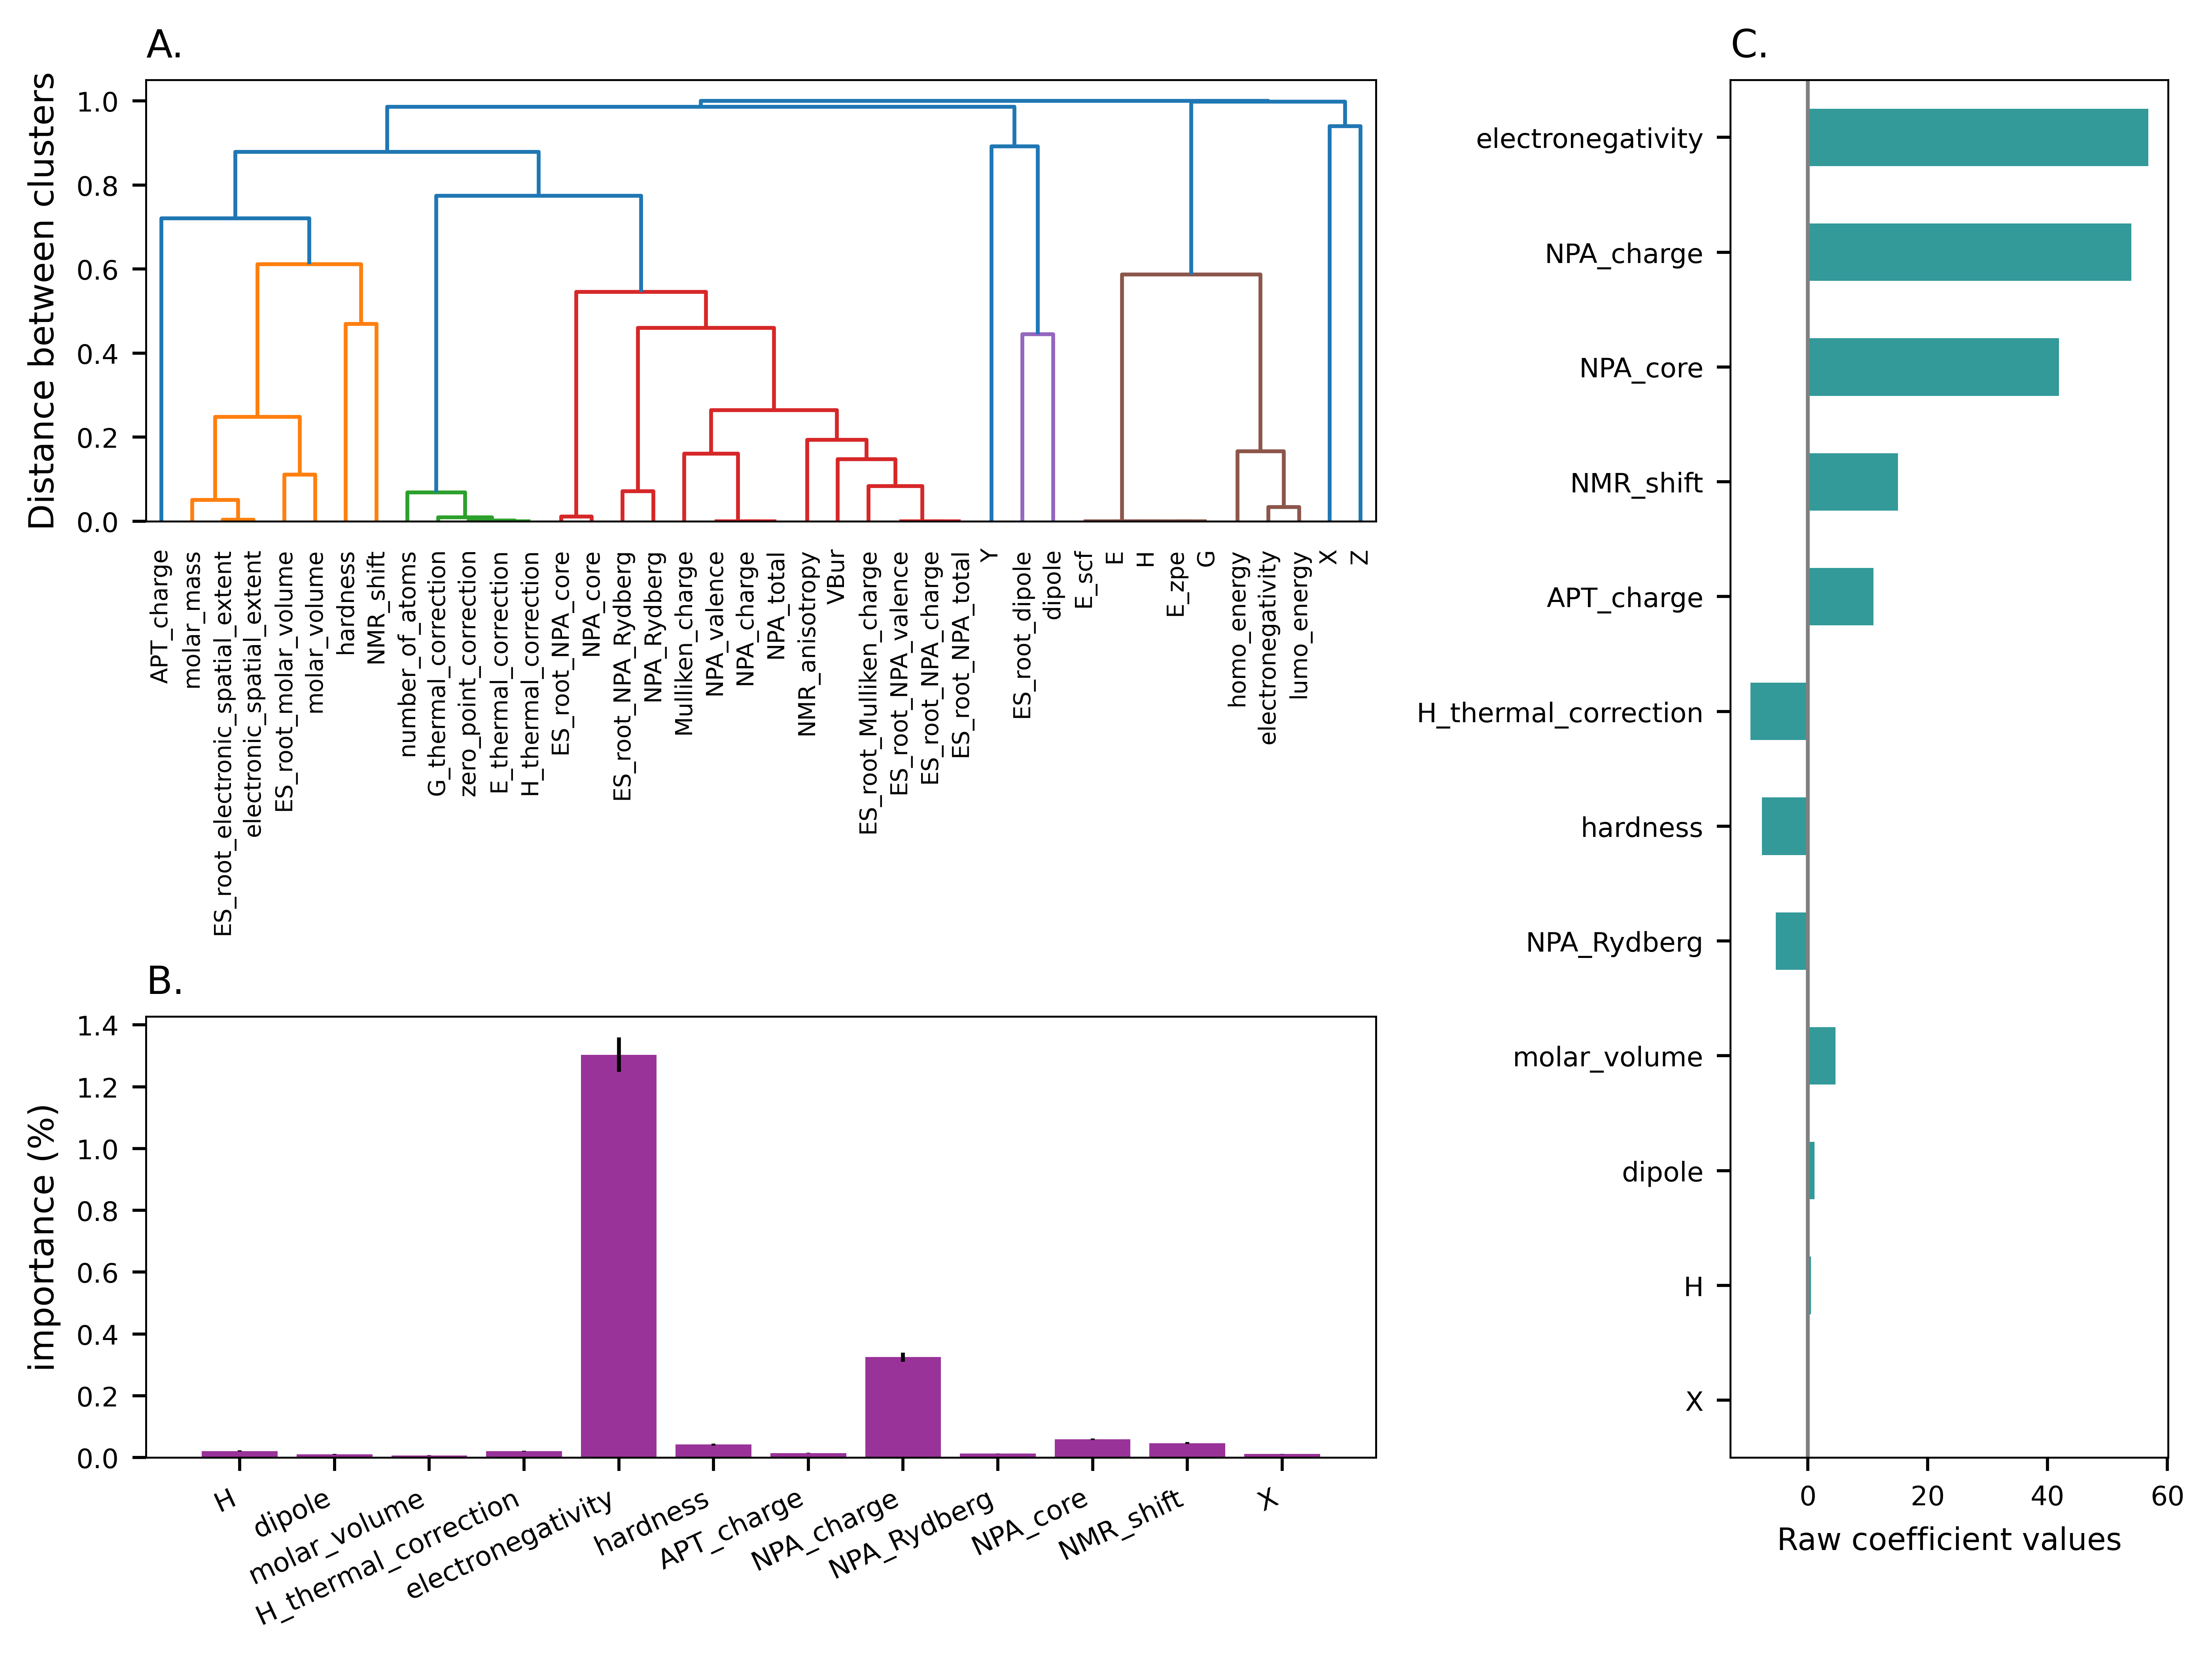

In [34]:
fig = plt.figure(figsize=(8, 6))

ax1 = plt.subplot2grid((2, 3), (0, 2), rowspan = 2)

ax2 = plt.subplot2grid((2, 3), (0, 0), colspan = 2)
ax3 = plt.subplot2grid((2, 3), (1, 0), colspan = 2)


more_important_coefs["Coefficients"].plot.barh(color = 'teal', alpha = 0.8, ax = ax1)
ax1.set_title('C.', loc='left', fontsize =10)
ax1.axvline(x=0, color=".5")
ax1.set_xlabel("Raw coefficient values")
#plt.subplots_adjust(left=0.3)





dendrogram = hierarchy.dendrogram(Z, labels=df_X.columns, orientation='top', 
           leaf_rotation=90, leaf_font_size = 6, ax = ax2);

ax2.set_ylabel("Distance between clusters", size = 9)
ax2.set_title('A.', loc='left', fontsize =10)


ax3.bar(feature_names, mean_importances, yerr = std, color = 'purple', alpha = 0.8)

plt.xticks(rotation=25, rotation_mode='default', ha = 'right', fontsize = 7)
ax3.set_title('B.', loc='left', fontsize =10)
ax3.set_ylabel('importance (%)', size = 9)
#plt.margins(0.2)



plt.tight_layout(w_pad = 1.5)


fig.savefig(f'../results/interpretability/quantum_descriptors/lewis_acidity_interpretability.png', facecolor = 'white', format = 'png', transparent = True, bbox_inches='tight')

In [145]:
df_X.NPA_core.std()

0.00016433017698321868

In [147]:
df_total['group']

SMILES
c1ccc2c(c1)OB1Oc3ccccc3-c3cccc-2c31                                                               Ohmiya
CC(C)(C)c1cc(Cl)c2c(c1)-c1cc(Cl)cc3c1B(O2)Oc1c(Cl)cc(C(C)(C)C)cc1-3                               Ohmiya
CC(C)(C)c1cc(F)c2c(c1)-c1cc(N)cc3c1B(O2)Oc1c(F)cc(C(C)(C)C)cc1-3                                  Ohmiya
CC(C)(C)c1cc2c(c([N+](=O)[O-])c1)OB1Oc3c(cc(C(C)(C)C)cc3[N+](=O)[O-])-c3cc(C#N)cc-2c31            Ohmiya
CC(C)(C)c1cc2c3c(c1)-c1cc(C#N)cc(C(C)(C)C)c1OB3Oc1c-2cc(C#N)cc1C(C)(C)C                           Ohmiya
                                                                                               ...      
Oc1cc(B(c2cc(O)c(Cl)c(O)c2)c2cc(O)c(Cl)c(O)c2)cc(O)c1Cl                                   triarylboranes
Oc1cc(B(c2cc(O)c(O)c(O)c2)c2cc(O)c(O)c(O)c2)cc(O)c1O                                      triarylboranes
Oc1cc(O)cc(B(c2cc(O)cc(O)c2)c2cc(O)cc(O)c2)c1                                             triarylboranes
Oc1ccc(B(c2ccc(O)cc2)c2ccc(O)cc2)cc1            

In [36]:
df_X['group']=list(df_total.group)

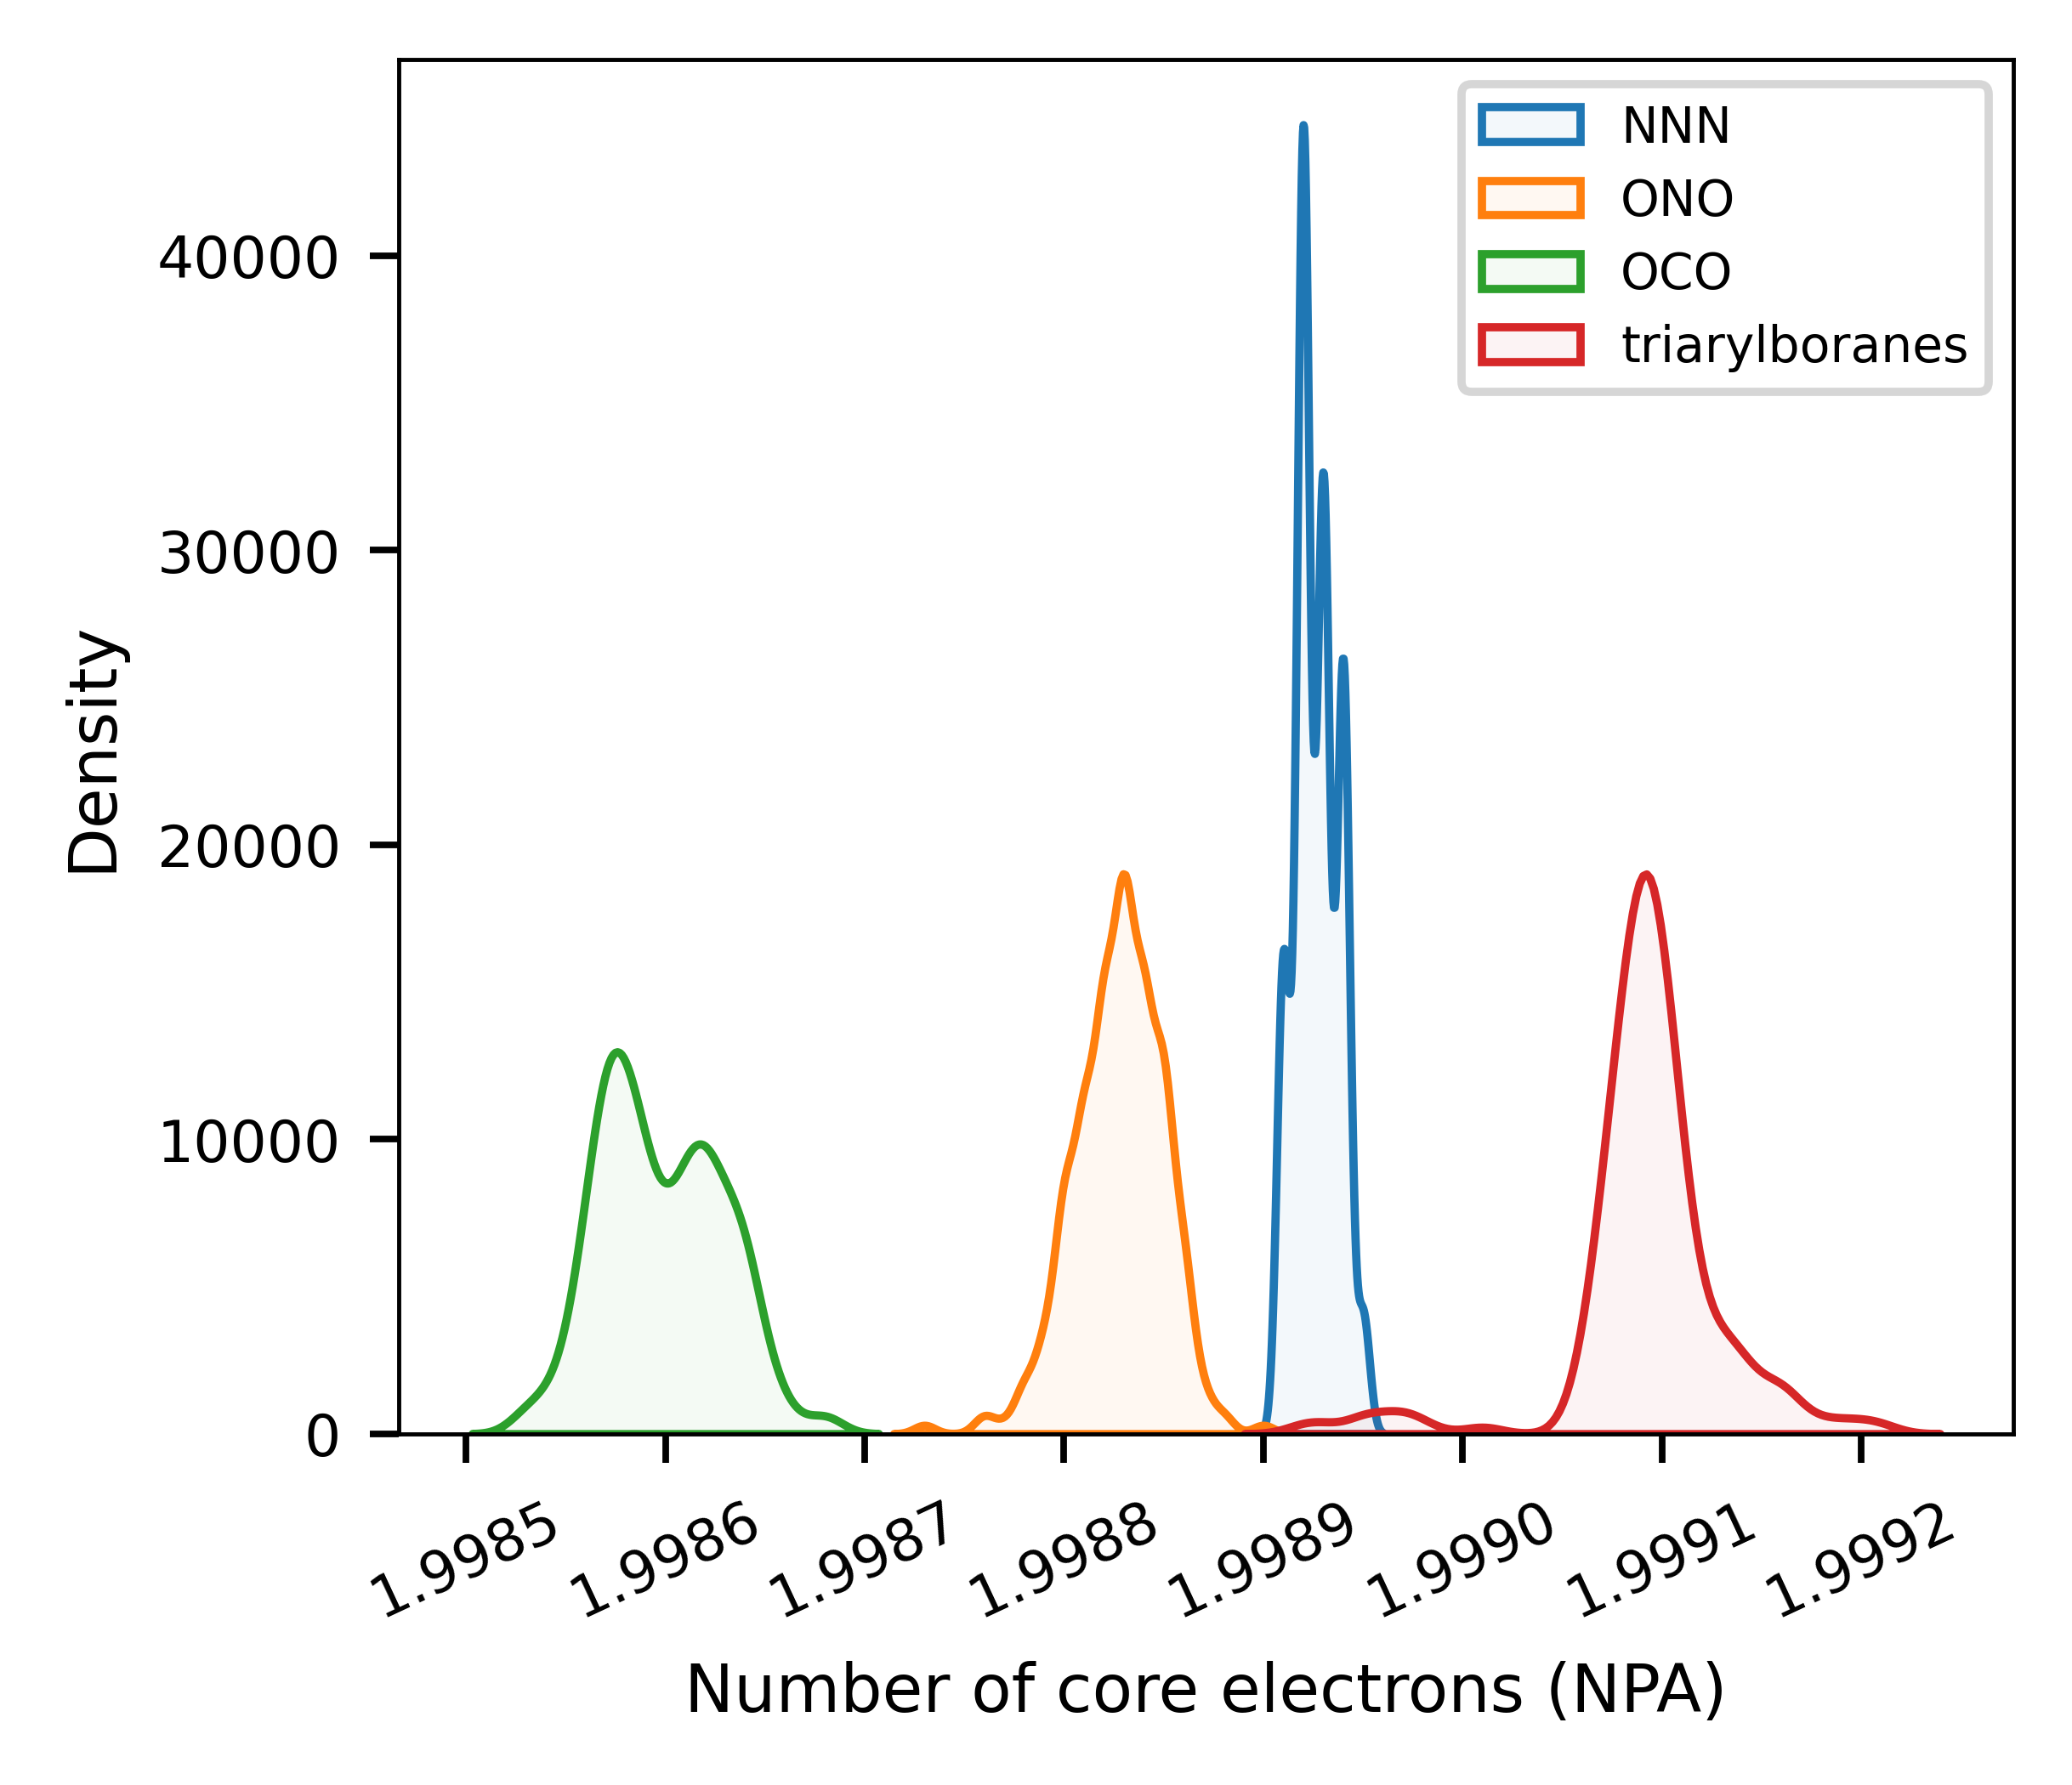

In [40]:
#sns.displot(df_total, x="FIA", kind ='kde', bw_adjust = 0.7, hue = 'group')
fig = plt.figure(figsize=(3.5, 3))

ax = fig.add_subplot()


bandwidth = 0.7
sns.kdeplot(df_X[df_X.group == 'NNN'], x="NPA_core", bw_adjust = bandwidth, label = 'NNN', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_X[df_X.group == 'ONO'], x="NPA_core", bw_adjust = bandwidth, label = 'ONO', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_X[df_X.group == 'OCO'], x="NPA_core", bw_adjust = bandwidth, label = 'OCO', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_X[df_X.group == 'triarylboranes'], x="NPA_core", bw_adjust = bandwidth, label = 'triarylboranes', fill =True, alpha=0.05, ax = ax)

ax.set_xlabel('Number of core electrons (NPA)')

ax.tick_params(axis = 'x',rotation=25)
ax.legend()

fig.savefig('../results/interpretability/quantum_descriptors/DB_distribution_of_NPA_core.png', format='png', transparent= True, facecolor='white', bbox_inches='tight')

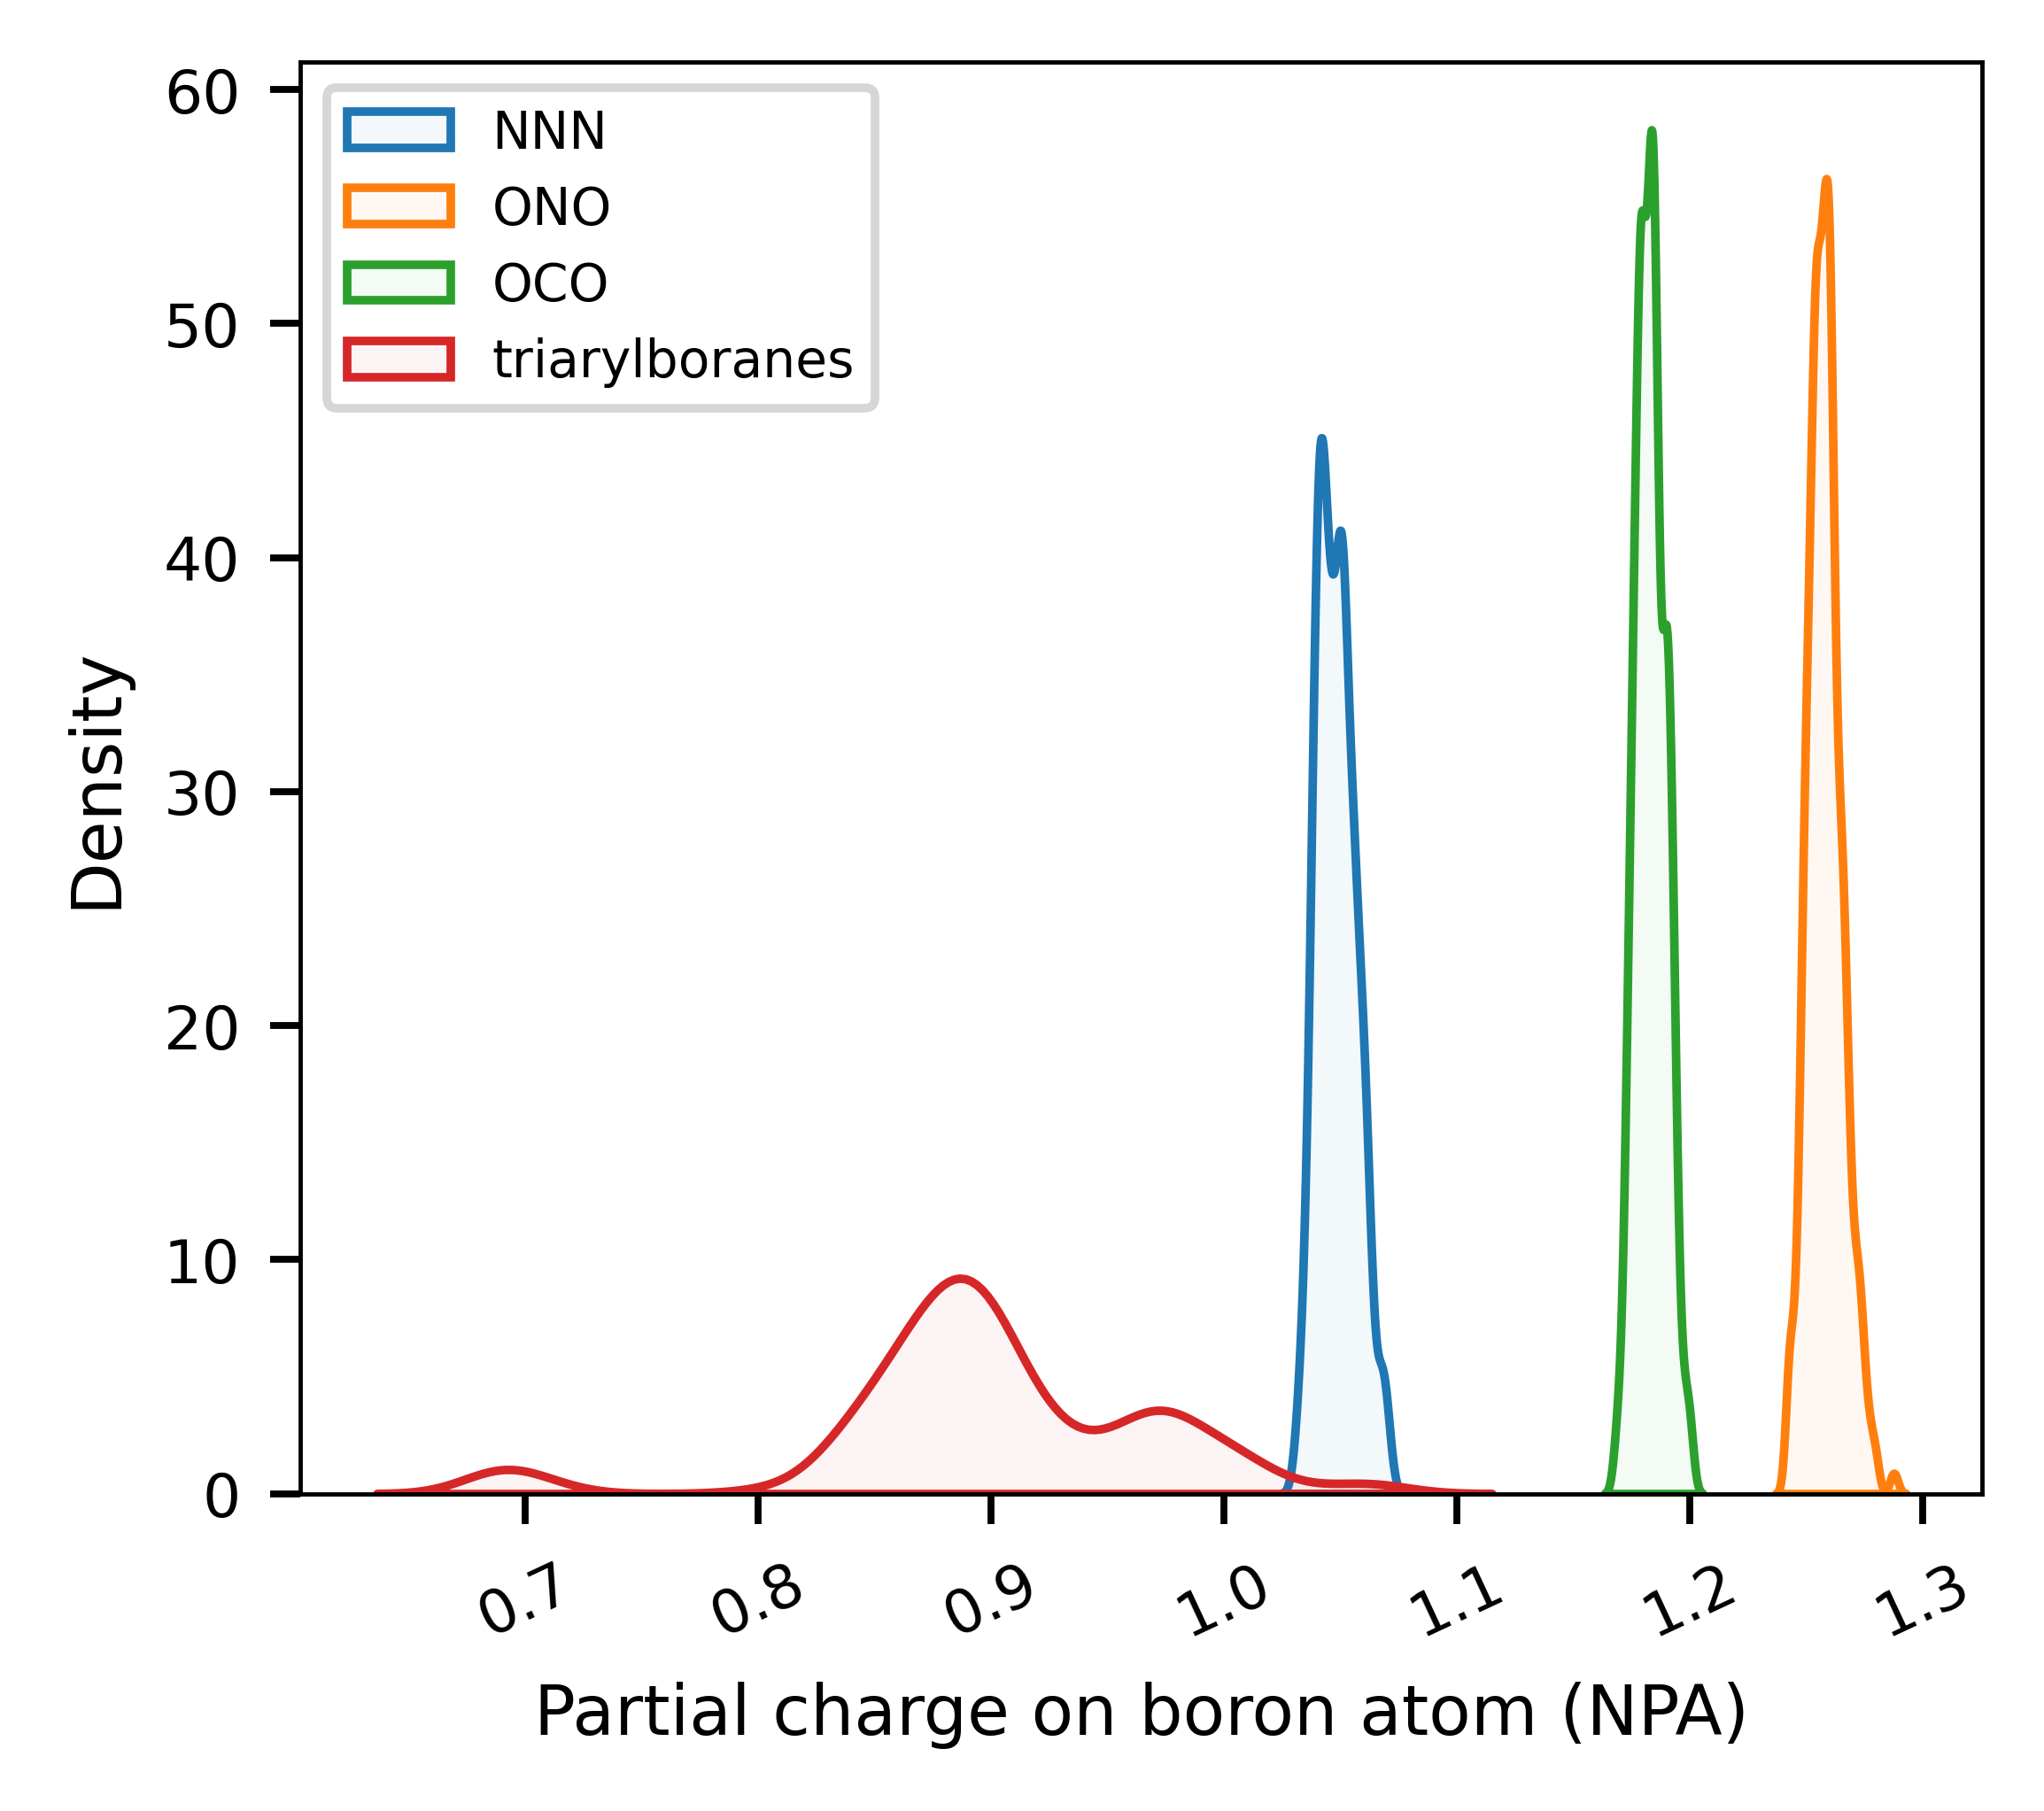

In [39]:
#sns.displot(df_total, x="FIA", kind ='kde', bw_adjust = 0.7, hue = 'group')
fig = plt.figure(figsize=(3.5, 3))

ax = fig.add_subplot()


bandwidth = 0.7
sns.kdeplot(df_X[df_X.group == 'NNN'], x="NPA_charge", bw_adjust = bandwidth, label = 'NNN', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_X[df_X.group == 'ONO'], x="NPA_charge", bw_adjust = bandwidth, label = 'ONO', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_X[df_X.group == 'OCO'], x="NPA_charge", bw_adjust = bandwidth, label = 'OCO', fill =True, alpha=0.05, ax = ax)
sns.kdeplot(df_X[df_X.group == 'triarylboranes'], x="NPA_charge", bw_adjust = bandwidth, label = 'triarylboranes', fill =True, alpha=0.05, ax = ax)

ax.set_xlabel('Partial charge on boron atom (NPA)')

ax.tick_params(axis = 'x',rotation=25)
ax.legend(loc = 'upper left')

## FIA as a function of absolute electronegativity and charge

In [5]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

norm = Normalize(vmin = 180, vmax = 610)
mappable = ScalarMappable(norm=norm, cmap='viridis')
colors = mappable.to_rgba(list(df_total.FIA))

In [13]:
X_ONO = create_descriptors(df_ONO.index, "quantum", data = data_Q_tot)
df_X_ONO = pd.DataFrame(X_ONO, columns = get_names('quantum'))
df_X_ONO['FIA']= list(df_ONO.FIA)

Text(0.5, 0, 'Absolute electronegativity $\\chi$ ($eV$)')

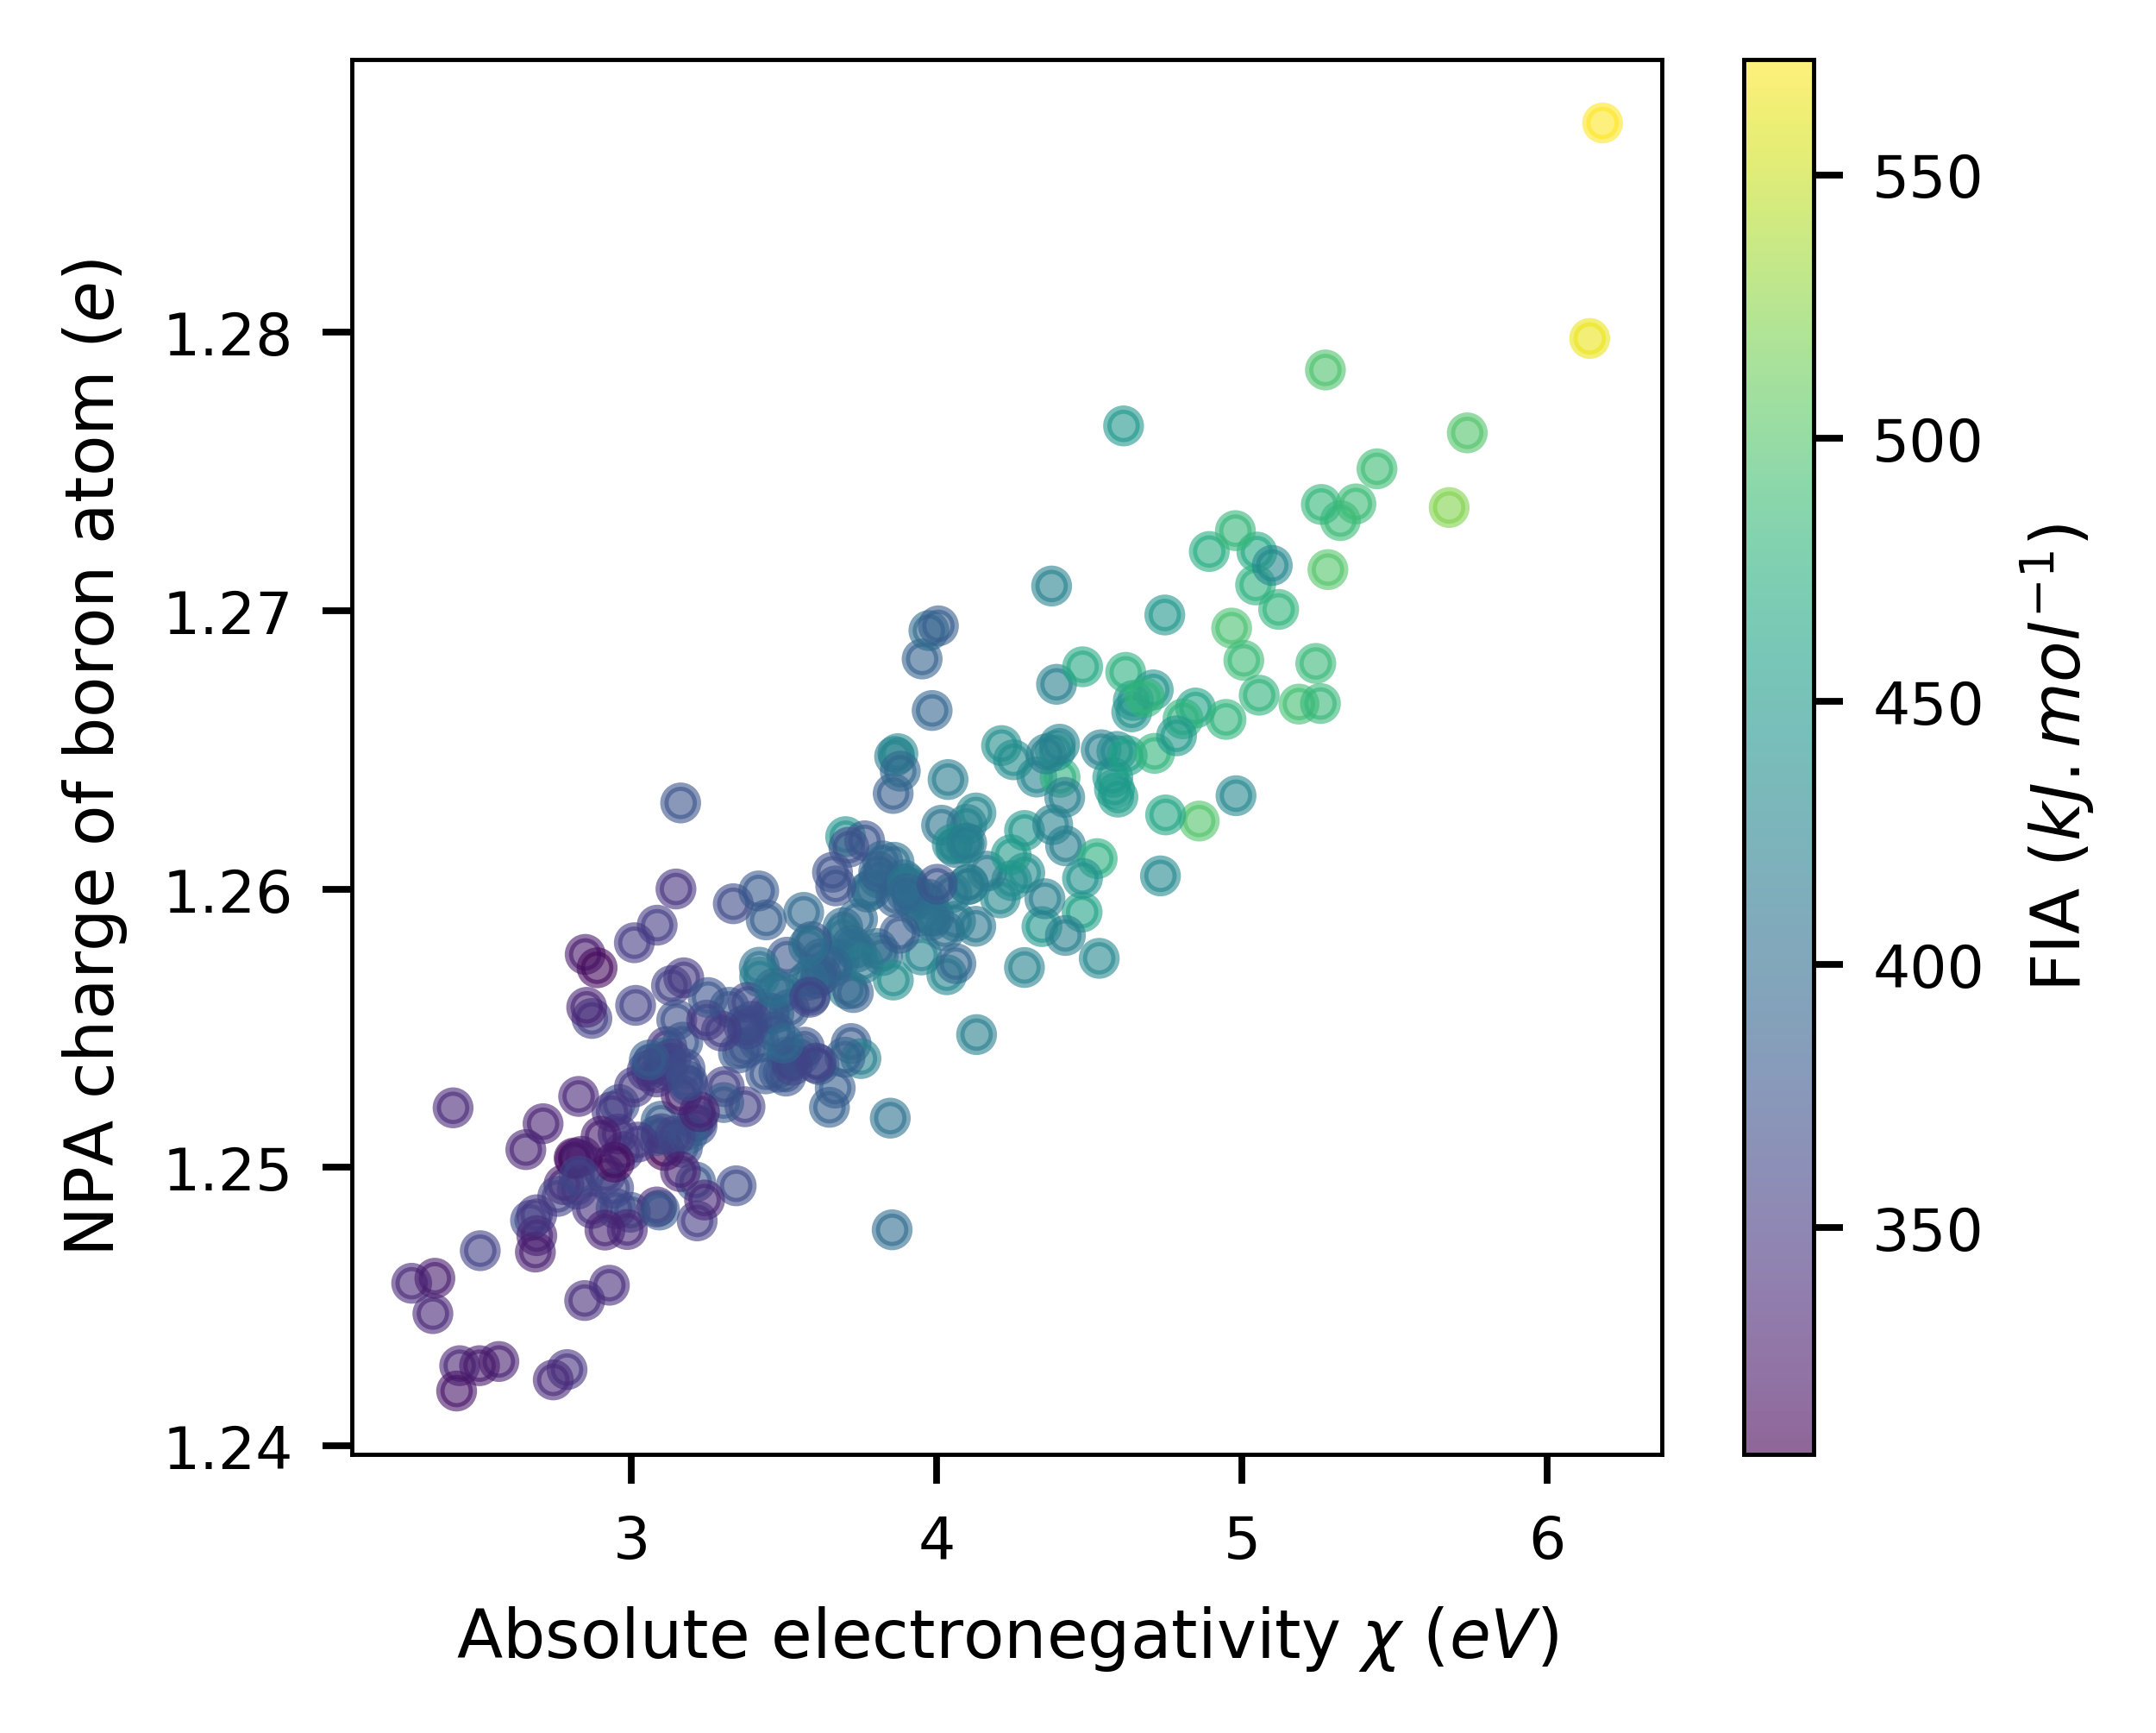

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 3))

electronegativity = df_X_ONO['electronegativity']*27.2107
charge = df_X_ONO['NPA_charge']

sc = ax.scatter(electronegativity, charge , s = 15, alpha = 0.6, c = df_X_ONO['FIA'])

cbar = fig.colorbar(sc,ax=ax, alpha = 0.6)
cbar.set_label("FIA ($kJ.mol^{-1}$)")

ax.set_ylabel('NPA charge of boron atom ($e$)')
ax.set_xlabel('Absolute electronegativity $\chi$ ($eV$)')

#ax.text(0.05, 0.95, 'FIA = 60.0 $\cdot \chi$ + 8.15 $\cdot$ NPA charge + 161 \n R²=0.88', transform=ax.transAxes,verticalalignment='top')

#fig.savefig(f'../results/interpretability/quantum_descriptors/FIA_electronegativity_charge_plot.png', facecolor = 'white', format = 'png', transparent = False, bbox_inches='tight')

In [5]:
X = create_descriptors(df_total.index, "quantum", data = data_Q_tot)
df_X = pd.DataFrame(X, columns = get_names('quantum'))
df_X['FIA']= list(df_total.FIA)

Text(0.5, 0, 'Absolute electronegativity $\\chi$ ($eV$)')

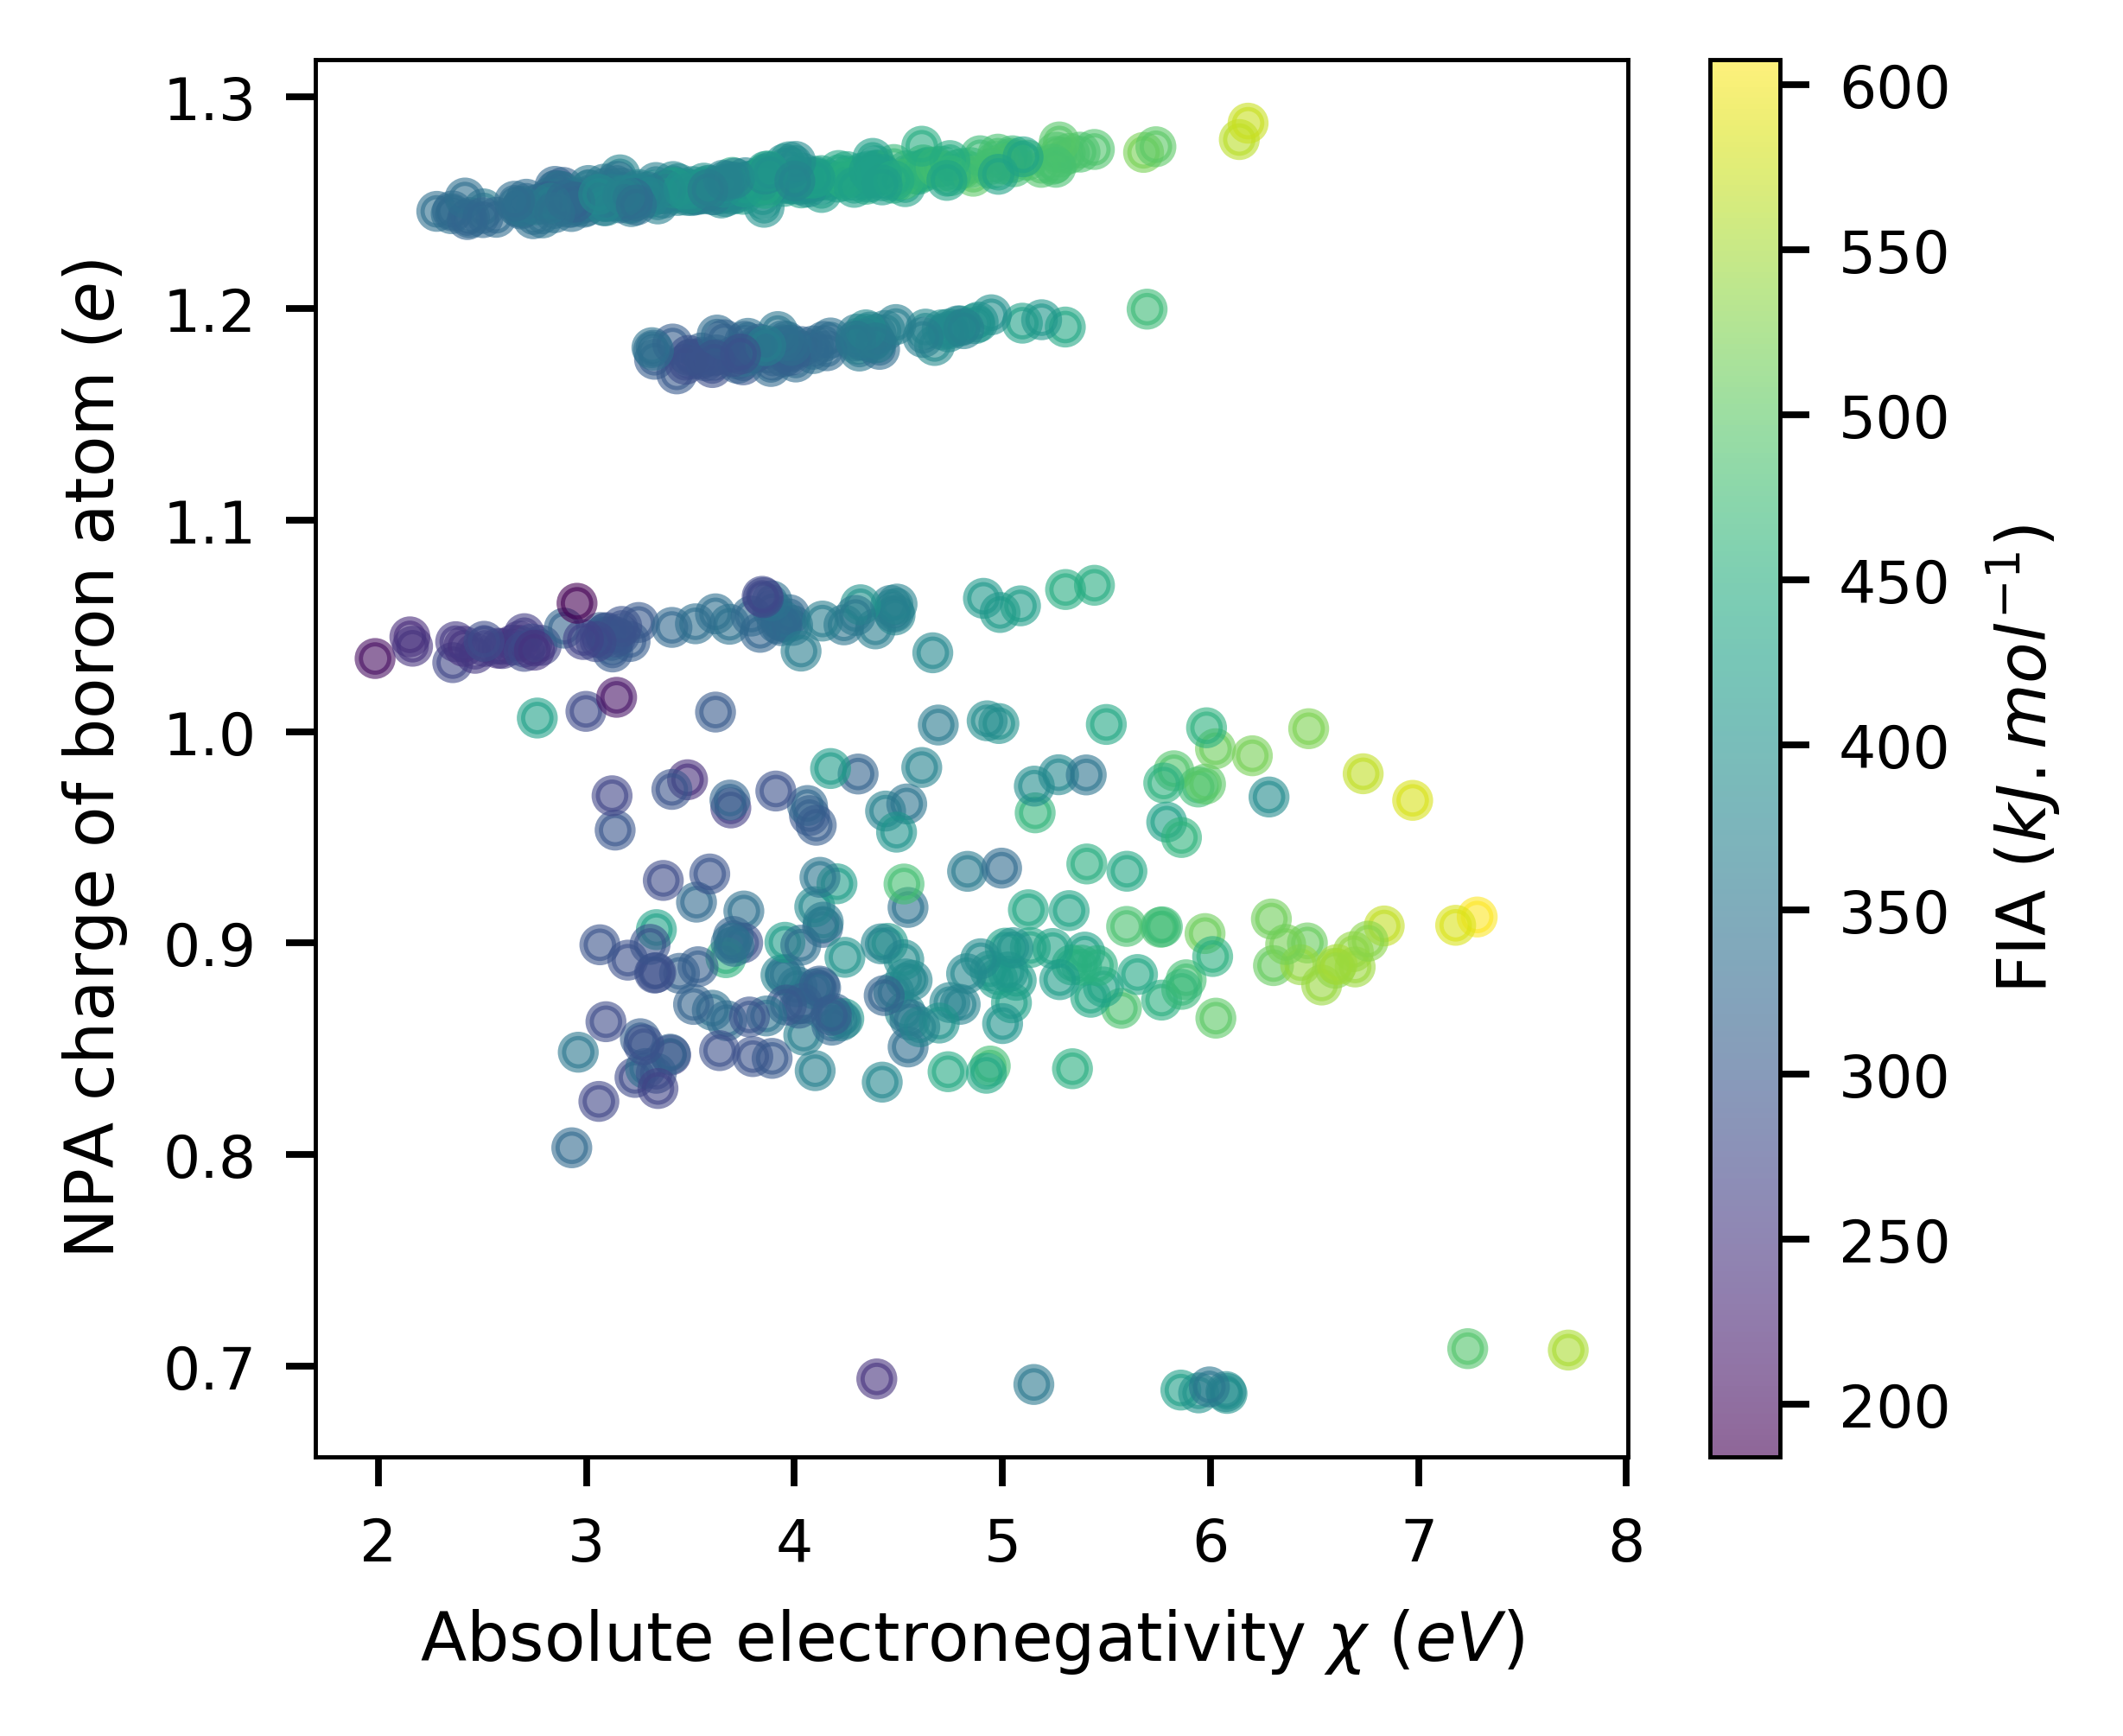

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 3))

electronegativity = df_X['electronegativity']*27.2107
charge = df_X['NPA_charge']

sc = ax.scatter(electronegativity, charge , s = 15, alpha = 0.6, c = df_X['FIA'])

cbar = fig.colorbar(sc,ax=ax, alpha = 0.6)
cbar.set_label("FIA ($kJ.mol^{-1}$)")

ax.set_ylabel('NPA charge of boron atom ($e$)')
ax.set_xlabel('Absolute electronegativity $\chi$ ($eV$)')

#ax.text(0.05, 0.95, 'FIA = 60.0 $\cdot \chi$ + 8.15 $\cdot$ NPA charge + 161 \n R²=0.88', transform=ax.transAxes,verticalalignment='top')

#fig.savefig(f'../results/interpretability/quantum_descriptors/FIA_electronegativity_charge_plot.png', facecolor = 'white', format = 'png', transparent = False, bbox_inches='tight')

In [16]:
df = pd.DataFrame()
df['electronegativity']=electronegativity
df['charge']=charge

In [17]:
model = LinearRegression()

model.fit(df, df_X_ONO.FIA)

LinearRegression()

In [18]:
model.coef_

array([60.05291232,  8.15295414])

In [19]:
model.intercept_

161.4548393641934

In [35]:
model.score(df, df_X_ONO.FIA)

0.8835193832013962

In [26]:
electronegativity

0      4.098340
1      3.719431
2      3.614397
3      3.891130
4      3.680927
         ...   
267    3.583649
268    3.222699
269    2.846783
270    3.182836
271    3.239570
Name: electronegativity, Length: 272, dtype: float64

In [27]:
charge

0      1.26232
1      1.25445
2      1.25369
3      1.26033
4      1.25745
        ...   
267    1.25611
268    1.25200
269    1.24522
270    1.25311
271    1.24883
Name: NPA_charge, Length: 272, dtype: float64

In [25]:
np.array(electronegativity, charge)

array([4.09833958, 3.71943058, 3.61439728, 3.8911301 , 3.68092744,
       5.05602017, 3.44133723, 3.58691447, 3.21494421, 3.95208207,
       3.16120307, 4.0622854 , 4.32745367, 3.44868412, 3.77289961,
       2.66950572, 3.73793386, 2.99671439, 4.25139977, 3.84772903,
       3.50936398, 4.0330339 , 3.37194994, 3.21535237, 3.09807425,
       3.08433284, 3.13113525, 4.34446036, 3.70147152, 4.40391574,
       4.10418988, 3.69235594, 3.61943126, 2.34978   , 3.70732182,
       3.11562515, 2.84855213, 2.6900498 , 4.06146908, 4.20786265,
       4.4760241 , 2.87181728, 3.4829696 , 3.33358286, 2.88759948,
       4.64377806, 3.46637107, 3.74051888, 3.60541775, 4.28827027,
       3.43997669, 3.16718943, 3.10827826, 2.78909675, 2.81549113,
       2.43753451, 3.69290015, 3.14841404, 2.50488099, 2.9153544 ,
       3.72092717, 3.1681418 , 3.41779997, 4.59330221, 3.95031337,
       2.96025205, 3.08283626, 3.75167526, 3.21426394, 3.35045349,
       3.18474033, 3.21018233, 3.99004099, 3.00977553, 3.10610